In [1]:
import numpy as np
import scipy.stats
import scipy.optimize

import matplotlib.pyplot as plt

import emcee

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as random
import jax.numpy as jnp
from jax.lax import cond
from jax import jit, hessian, vmap

import jaxopt

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import getdist
import getdist.plots

import bayesian_stats_course_tools.analyse
from bayesian_stats_course_tools.plotting import plot_contours

import warnings
warnings.simplefilter("ignore")

In [2]:
title = "# Interpreting posteriors and recap"
# Print title and setup TeX defs for both KaTeX and MathJax
import bayesian_stats_course_tools
bayesian_stats_course_tools.misc.display_markdown_and_setup_tex(title)

import matplotlib.style
matplotlib.style.use("bayesian_stats_course_tools.light")

# Interpreting posteriors and recap

<!-- Define LaTeX macros -->
$\def\E{\operatorname{E}}$
$\def\Var{\operatorname{Var}}$
$\def\Cov{\operatorname{Cov}}$
$\def\dd{\mathrm{d}}$
$\def\ee{\mathrm{e}}$
$\def\Norm{\mathcal{N}}$
$\def\Uniform{\mathcal{U}}$

<!-- MathJax needs them to be defined again for the non-inline environment -->
$$\def\E{\operatorname{E}}$$
$$\def\Var{\operatorname{Var}}$$
$$\def\Cov{\operatorname{Cov}}$$
$$\def\dd{\mathrm{d}}$$
$$\def\ee{\mathrm{e}}$$
$$\def\Norm{\mathcal{N}}$$
$$\def\Uniform{\mathcal{U}}$$

We have evaluated and sampled a few posteriors so far. As Bayesians, that is the end-goal, since the full posterior distribution is what we care about.

In practice, we need to summarise the posterior in a form that allows it to be represented on a sheet of paper.



- Mode of the posterior 
    - pro: summary of the full $n$-dimensional joint posterior
    - con: point estimate, uncertainty is hard to define in practice
- Credible intervals
    - pro: intuitive interpretation, can be put in a table
    - con: only applies to 1D (marginal) distributions, can suffer from projection effects
- Corner plots
    - pro: more information than credible intervals due to showing 2D marginals as well
    - con: still only marginals, can suffer from projection effects

#### Credible interval or region

A credible region for a probability distribution $p(x)$ is a set $\Omega(\alpha)$ such that the probability enclosed within that region is $1-\alpha$:
$$
    \int_{\Omega(\alpha)} p(x)\dd x = 1 - \alpha\,.
$$

There are infinitely many ways to define such regions but two common ones are 
- equal-tail intervals
- highest posterior density intervals

The equal-tail interval $(x_\mathrm{L}, x_\mathrm{R})$ is defined by requiring the tails of the distribution to each contain $\frac{\alpha}{2}$ of the total probability. 
$$
    \mathrm{CDF}(x_\mathrm{L}) = \frac{\alpha}{2}, \quad 1-\mathrm{CDF}(x_\mathrm{R}) = 1-\frac{\alpha}{2}
$$

The equal-tail interval is centred on the median of $p(x)$. The equal-tail interval has the advantage that it is easy to compute, for example from samples from a posterior.

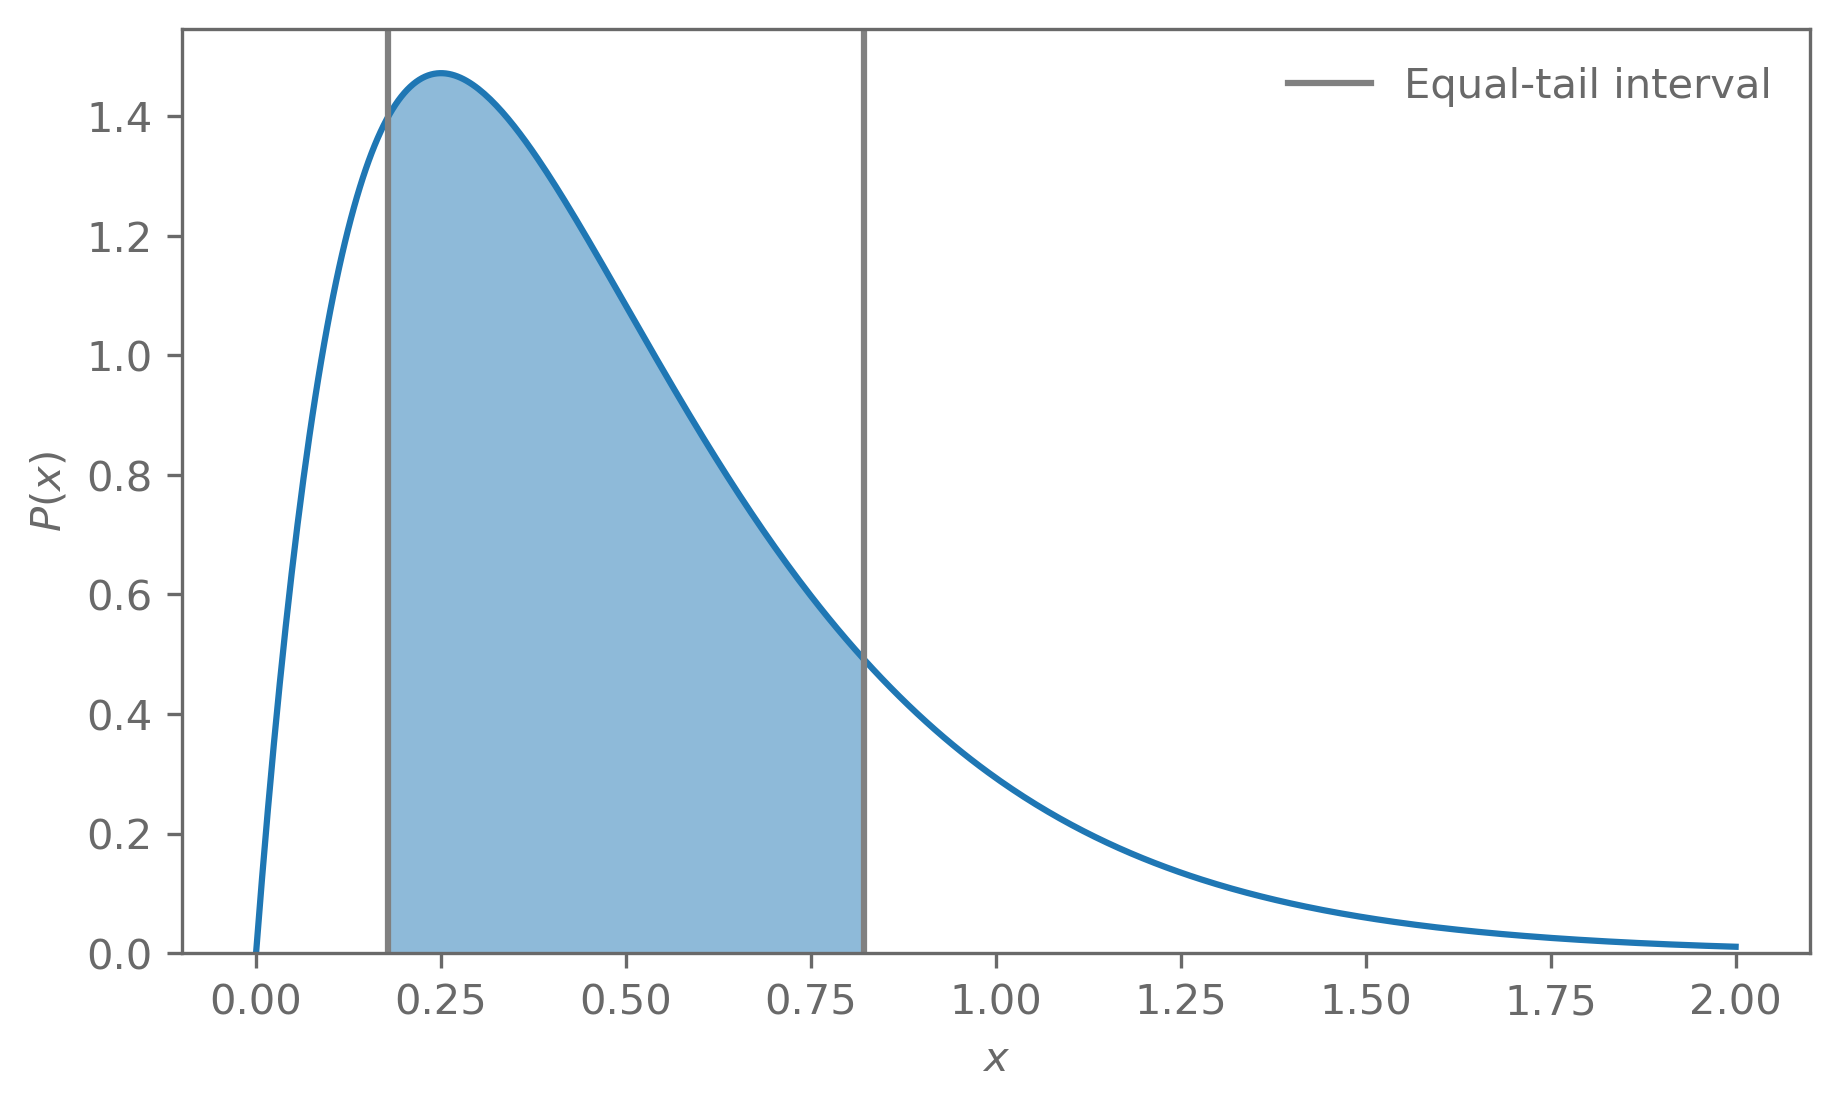

In [3]:
distr = scipy.stats.gamma(a=2, scale=1/4)

alpha = 1-0.68

x = np.linspace(0, 2, 500)

ci = distr.ppf(alpha/2), distr.ppf(1 - alpha/2)

plt.plot(x, distr.pdf(x))
x_ci = np.linspace(ci[0], ci[1], 100)
plt.fill_between(x_ci, 0, distr.pdf(x_ci), alpha=0.5)

plt.axvline(x=ci[0], c="grey", label="Equal-tail interval")
plt.axvline(x=ci[1], c="grey")

plt.ylim(bottom=0)

plt.xlabel("$x$")
plt.ylabel("$P(x)$")

_ = plt.legend()

The highest-density interval (or region) is defined as the region for which $p(x)$ is above a threshold $c_\alpha$, such that
$$
    \int_{\Omega(\alpha)} p(x)\dd x = 1 - \alpha\,,
$$
where
$$
    \Omega(\alpha) = \{x| p(x) > c_\alpha\}\,.
$$



The highest-density regions are the smallest possible credible region that can be defined. It is centred on the mode of $p(x)$.

The downside is that it is more complicated to compute (even in 1D). 

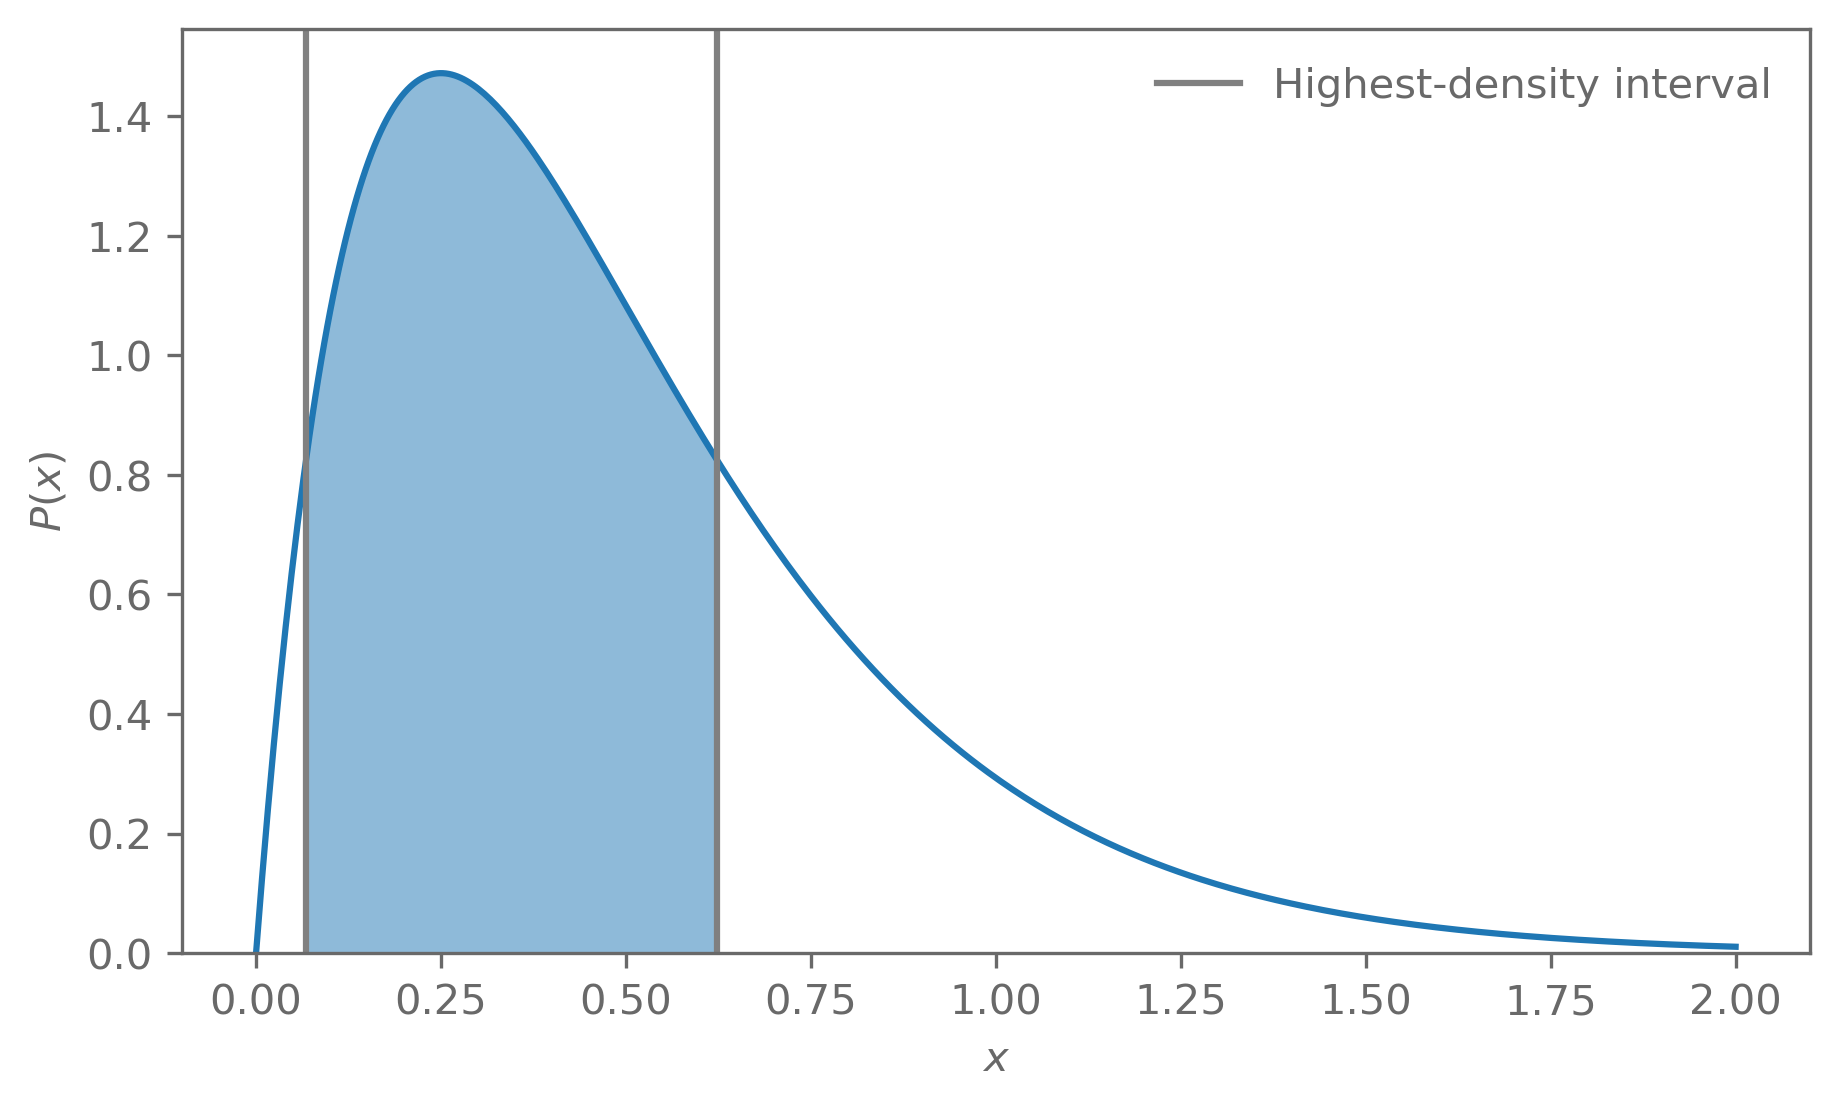

In [4]:
def find_ci(alpha, pdf_fn, mode, support):
    def c_to_alpha(c):
        ci_L = scipy.optimize.root_scalar(
            f=lambda x: c-pdf_fn(x),
            bracket=(support[0], mode)).root
        ci_R = scipy.optimize.root_scalar(
            f=lambda x: c-pdf_fn(x),
            bracket=(mode, support[1])).root
        alpha = distr.cdf(ci_R) - distr.cdf(ci_L)
        return alpha, (ci_L, ci_R)
    
    min_c = max(pdf_fn(support[0]), pdf_fn(support[1]))

    c = scipy.optimize.root_scalar(
        f=lambda c: c_to_alpha(c)[0] - alpha,
        bracket=(min_c, pdf_fn(mode))).root
    
    return c_to_alpha(c)[1]

mode = scipy.optimize.minimize(lambda x: -distr.logpdf(x), x0=1.0).x.squeeze()

ci = find_ci(alpha=0.68, pdf_fn=distr.pdf, mode=mode, support=(0, 2))

plt.plot(x, distr.pdf(x))
x_ci = np.linspace(ci[0], ci[1], 100)
plt.fill_between(x_ci, 0, distr.pdf(x_ci), alpha=0.5)

plt.axvline(x=ci[0], c="grey", label="Highest-density interval")
plt.axvline(x=ci[1], c="grey")

plt.ylim(bottom=0)

plt.xlabel("$x$")
plt.ylabel("$P(x)$")

_ = plt.legend()


<img style="display: block; 
    margin-left: auto;
    margin-right: auto;
    width: 70%;"
    src="../assets/hpd_animation.gif" alt="HPD"/>

#### Projection effects

Once we have more than 2 dimensions in our posterior, we can only visualise marginal distributions of it (unless you use a fancy 3D plotting library).

These marginal distributions can behave in unintuitive ways when the posterior is not symmetric and Gaussian.

In [5]:
def model(x, a, b, c, d):
    x0=0.5
    return a + b * x * ((1+x)/(1+x0))**c * ((1+x**2)/(1+x0**2))**d

In [6]:
a_prior = tfd.Uniform(low=-10, high=10)
b_prior = tfd.Uniform(low=-10, high=10)
c_prior = tfd.Uniform(low=-1000, high=1000)
d_prior = tfd.Uniform(low=-1000, high=1000)


# Generate synthetic data
np.random.seed(42)
x = jnp.linspace(0, 1, 10)
true_params = [2, 0.1, 0, 0]
y = model(x, *true_params)
y_err = 0.05 * jnp.ones_like(y)


def create_likelihood_distribution(model, y_err):
    def distr(params, x):
        mu = model(x, *params)
        return tfd.MultivariateNormalDiag(loc=mu, scale_diag=y_err)

    return distr


def log_likelihood(params):
    return create_likelihood_distribution(model=model, y_err=y_err)(params, x).log_prob(y)

def log_prior(params):
    return a_prior.log_prob(params[0]) + b_prior.log_prob(params[1]) + c_prior.log_prob(params[2]) + d_prior.log_prob(params[3])

# Define the log posterior
def log_posterior(params):
    return log_likelihood(params) + log_prior(params)


In [7]:
params_initial = jnp.array([1.0, 1.0, 1.0, 1.0])
param_names = ["a", "b", "c", "d"]

solver = jaxopt.ScipyMinimize(fun=jit(lambda x: -log_posterior(x)), method="L-BFGS-B")
solution = solver.run(params_initial)
MAP_params = solution.params
cov = jnp.linalg.inv(-hessian(log_posterior)(MAP_params))

print("Model 1")
for name, p, p_std, p_true in zip(param_names, MAP_params, np.sqrt(np.diag(cov)), true_params):
    print(f"{name} = {p:.2f} ± {p_std:.2f} (truth: {p_true:.2f})")


Model 1
a = 2.00 ± 0.05 (truth: 2.00)
b = 0.10 ± 0.11 (truth: 0.10)
c = 0.28 ± 18.64 (truth: 0.00)
d = -0.17 ± 11.37 (truth: 0.00)


In [8]:

# Set up the initial parameters for the MCMC
initial_params = np.array([1.0, 1.0, 1.0, 1.0])
ndim = len(initial_params)
nwalkers = 32
nsteps = 10000

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, jit(vmap(log_posterior)), vectorize=True)

# Initialize the walkers
p0 = np.random.normal(initial_params, scale=0.1, size=(nwalkers, ndim))

# Run the MCMC
sampler.run_mcmc(p0, nsteps, progress=True)

max_autocorr = max(sampler.get_autocorr_time())
# Extract the samples
samples = sampler.get_chain(discard=int(5*max_autocorr), thin=int(max_autocorr/2), flat=True)

100%|██████████| 10000/10000 [00:03<00:00, 2667.46it/s]


In [9]:
getdist_samples = getdist.MCSamples(
    samples=samples,
    names=param_names,
    label="Model 1",
    ranges={"c": (-1000, 1000), "d": (-1000, 1000)}
)

Removed no burn in


In [10]:
g = getdist.plots.get_single_plotter()

<Figure size 1800x1350 with 0 Axes>

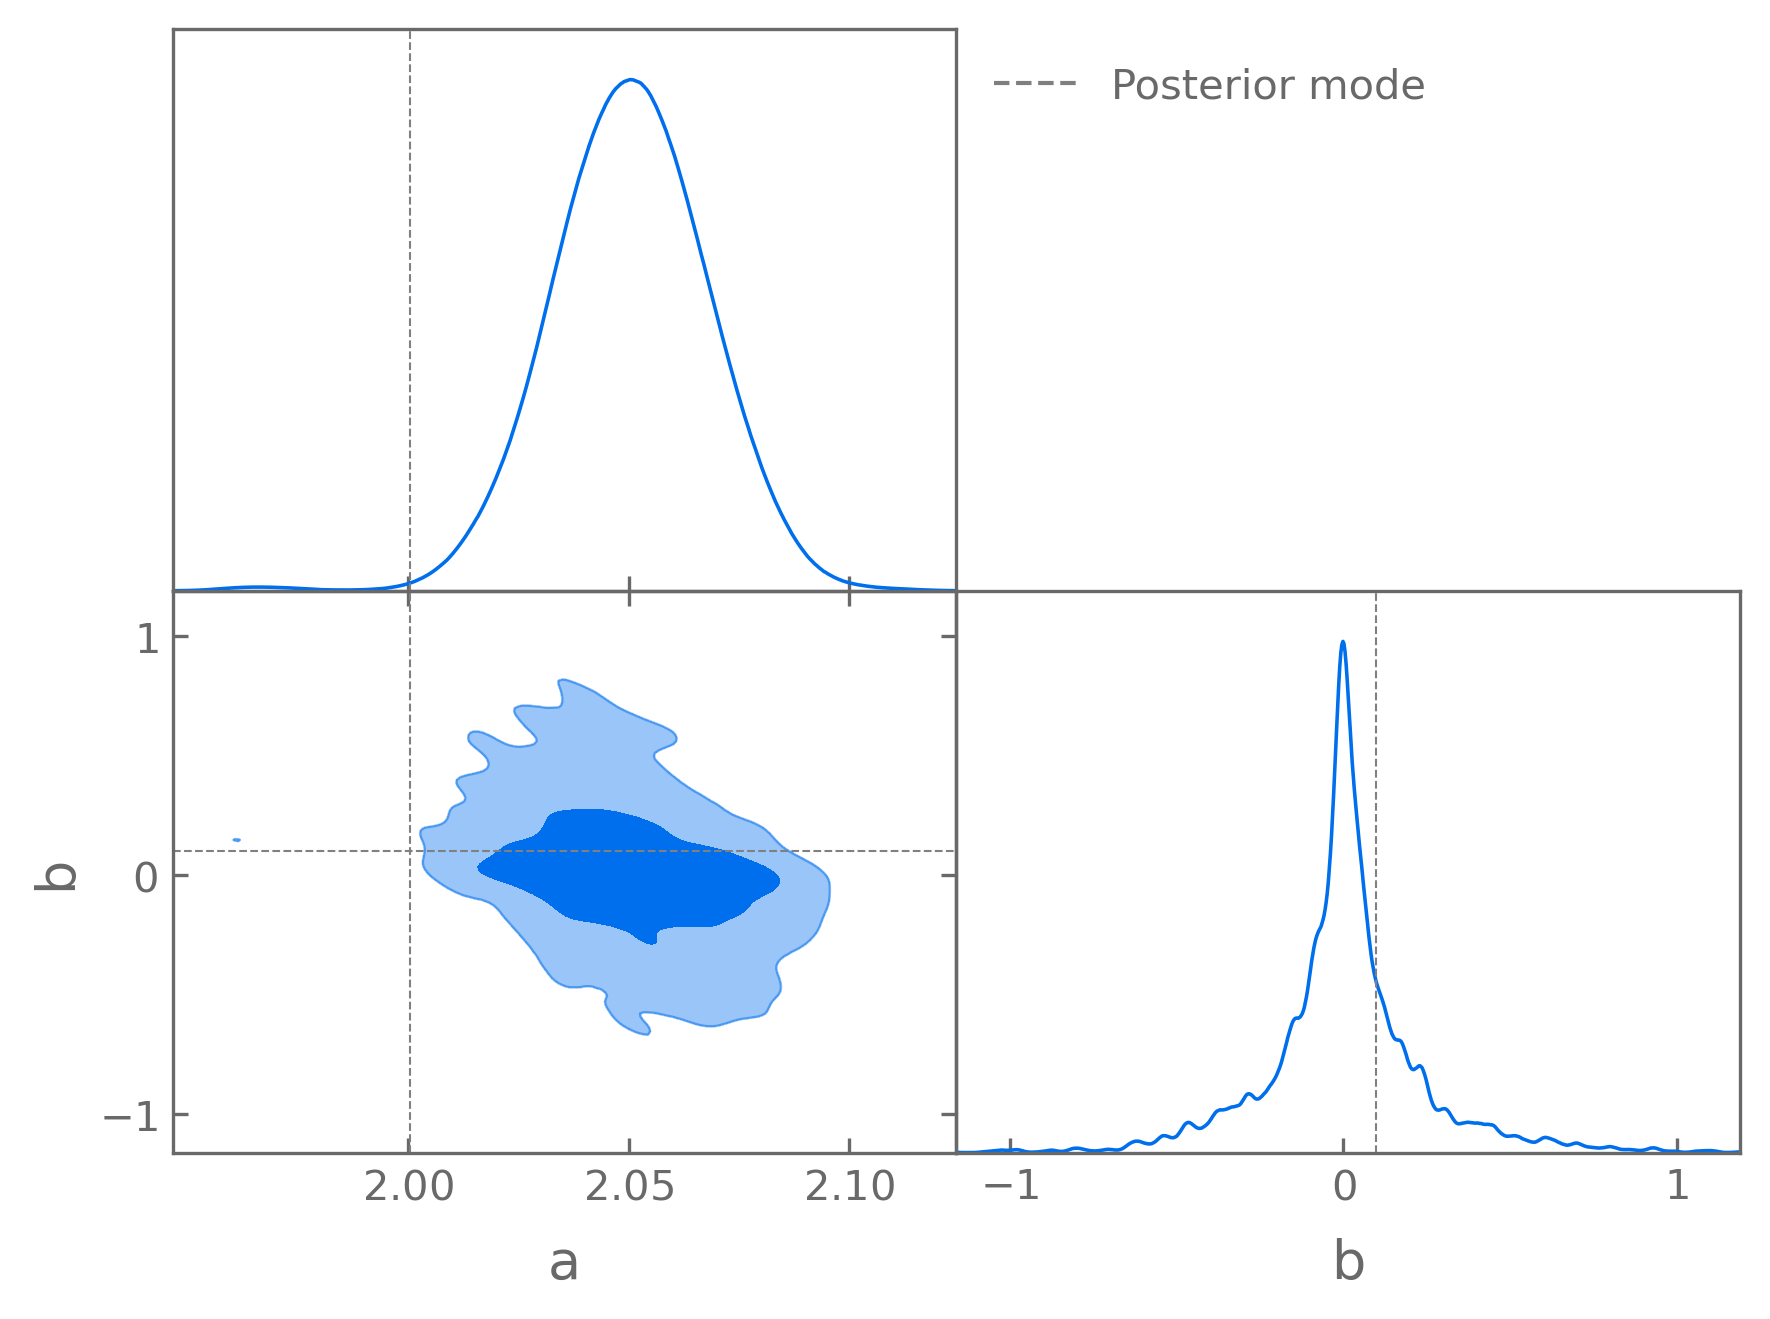

In [11]:
g.triangle_plot([getdist_samples],
                params=["a", "b"],
                filled=True,
                markers={k: v for k, v in zip(param_names, MAP_params)})

g.subplots[0,0].plot([],[], **{"lw" : 1.0, "ls" : "--", "c" : "k", "alpha" : 0.5}, label="Posterior mode")
g.subplots[0,0].legend(frameon=False, loc=2, bbox_to_anchor=(1,1));

In [12]:
g = getdist.plots.get_single_plotter()

<Figure size 1800x1350 with 0 Axes>

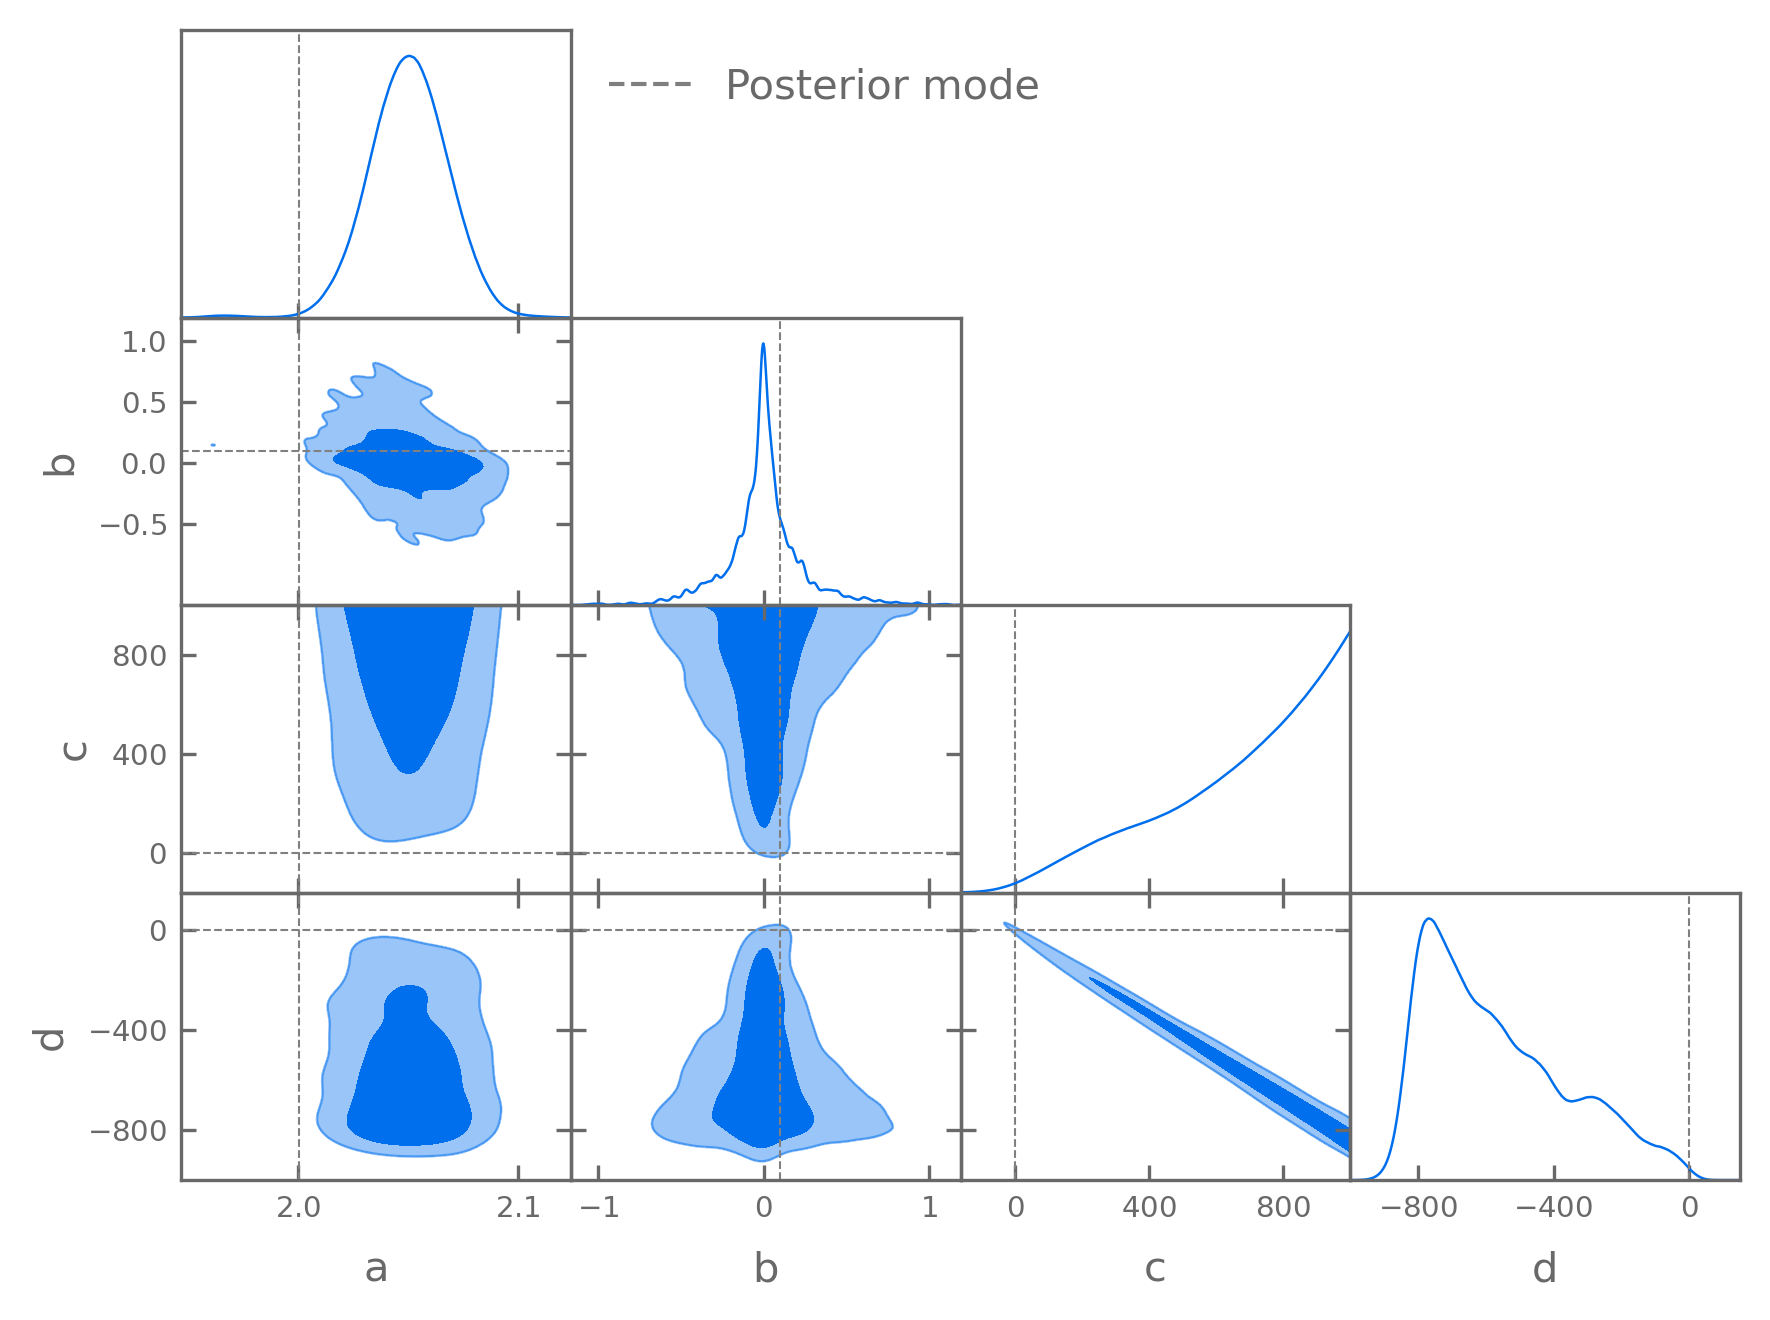

In [13]:
fig = g.triangle_plot([getdist_samples], filled=True,
                 markers={k: v for k, v in zip(param_names, MAP_params)})
g.subplots[0,0].plot([],[], **{"lw" : 1.0, "ls" : "--", "c" : "k", "alpha" : 0.5}, label="Posterior mode")
g.subplots[0,0].legend(frameon=False, loc=2, bbox_to_anchor=(1,1));

The model here is
$$
    \mu = a + bx  \left(\frac{1+x}{1 + x_0}\right)^c \left(\frac{1+x^2}{1 + x_0^2}\right)^d\,,
$$
for parameters $a$, $b$, $c$, $d$, with $x_0=0.5$.

When $b\approx 0$, the terms involving $c$ and $d$ do not contribute to the model anymore and $c$ and $d$ are not constrained.

Depending on how the prior is chosen, this can lead to large volumes of posterior space where $b\approx 0$.

When projecting the posterior into marginal distributions, this leads to marginals that are not centred on the mode of the joint posterior.

This can be seen with very skewed distributions even in 2 dimensions:

In [14]:
def log_p(p):
    x, y = p
    if y < 0 or x < 0 or y > x or y < x/2:
        return -np.inf
    
    return -(x+y)**2

theta_fid = (0.5, 0.5)
nwalkers = 32
ndim = len(theta_fid)

n_sample = 12000
burn_in = 2000

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_p)

sampler.run_mcmc(np.random.normal(loc=0, scale=0.1, size=(nwalkers,ndim))+theta_fid, n_sample, progress=True)
max_autocorr = max(sampler.get_autocorr_time())

samples = getdist.MCSamples(name_tag="Full",
                            samples=sampler.get_chain(flat=True, discard=int(5*max_autocorr), thin=int(max_autocorr/2)),
                            names=["theta0", "theta1"], labels=["x", "y"],
                            ranges={"theta0" : [0,4], "theta1" : [0,4],}
                                   )

100%|██████████| 12000/12000 [00:02<00:00, 4749.10it/s]

Removed no burn in


In [15]:
MAP = [0,0]

samples.smooth_scale_1D = 0.2
samples.smooth_scale_2D = 0.2

g = getdist.plots.get_single_plotter()
g.settings.legend_frame = False


<Figure size 1800x1350 with 0 Axes>

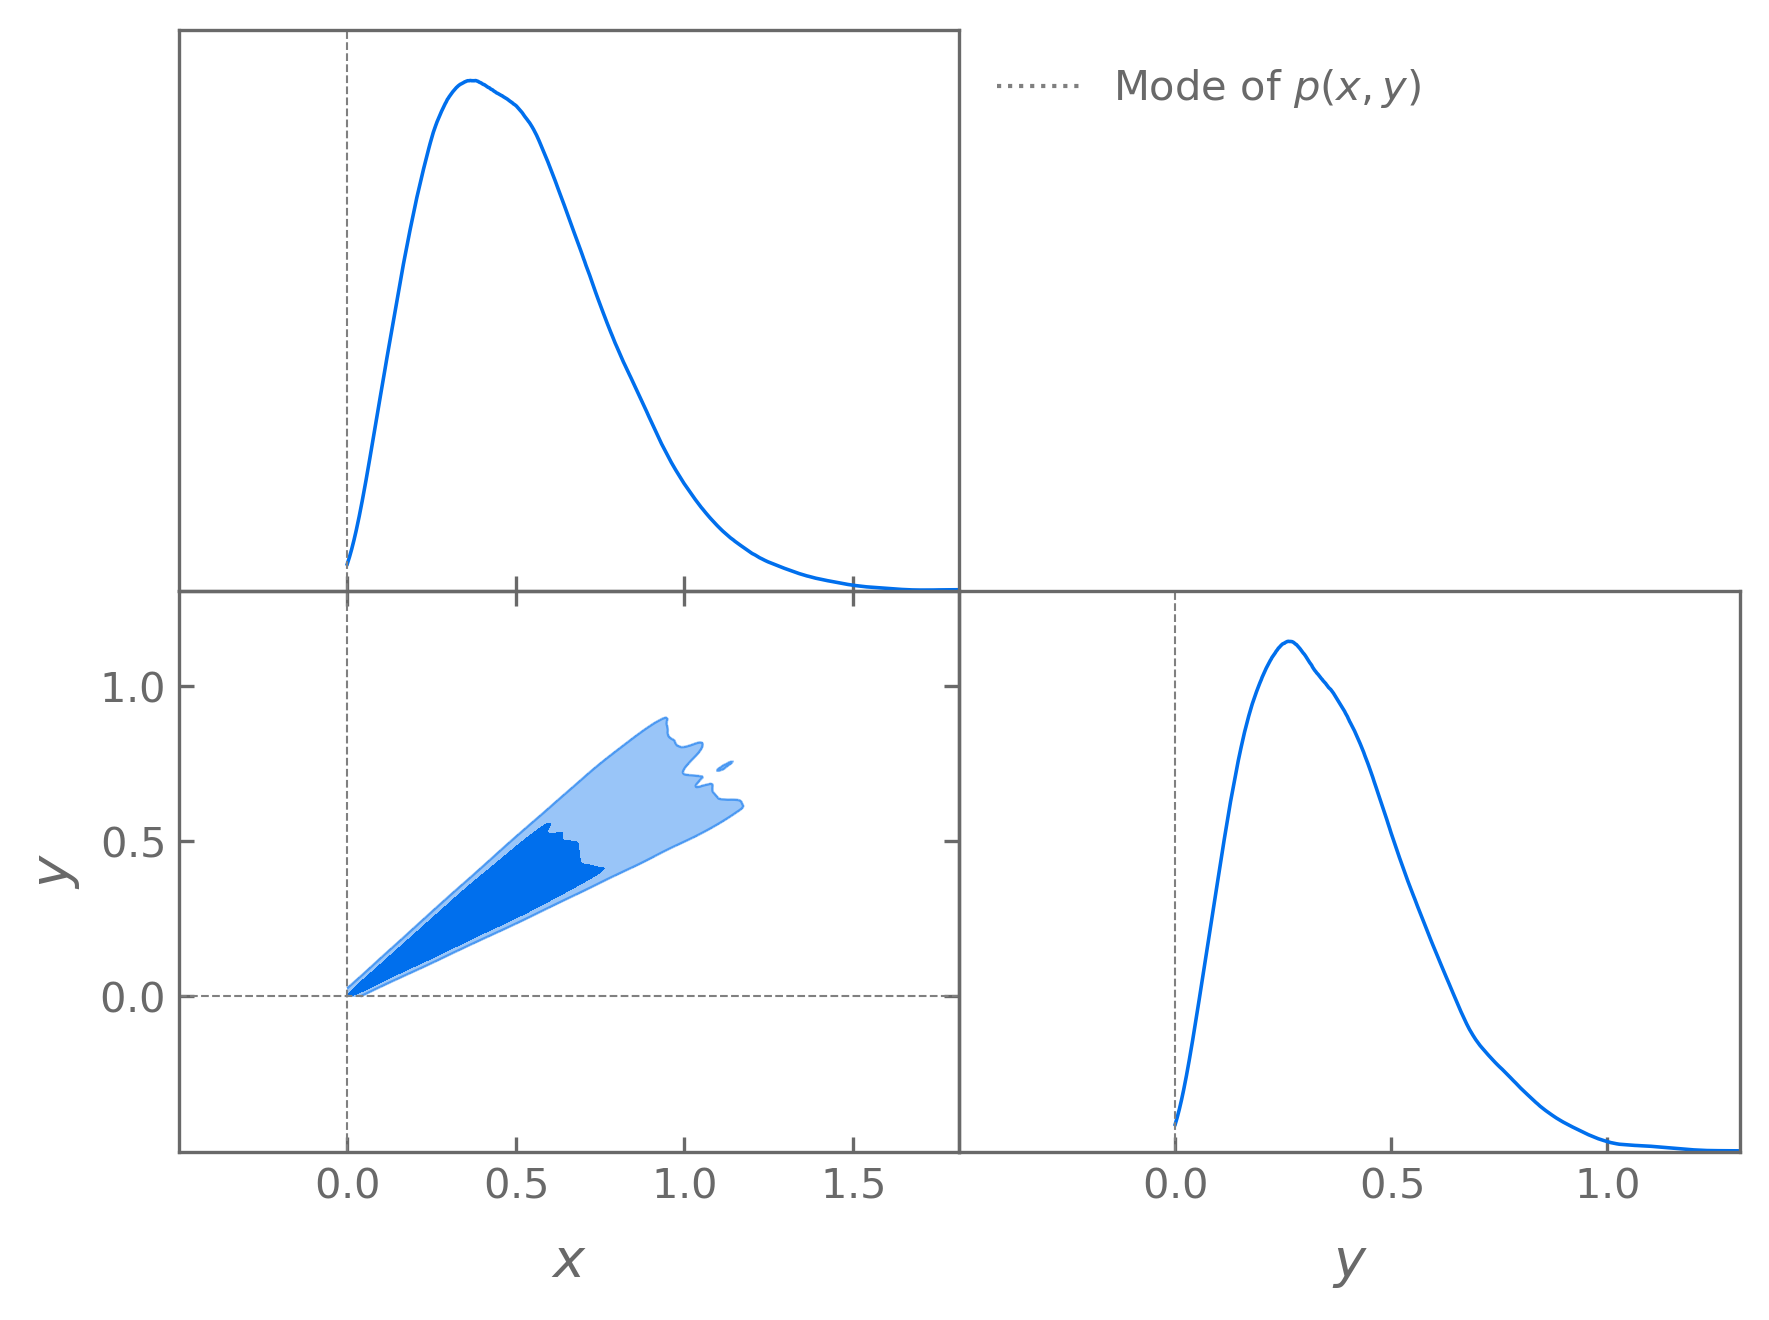

In [16]:

g.triangle_plot([samples],
                filled_compare=True,
                params=["theta0", "theta1"],
                markers={"theta0" : MAP[0], 
                         "theta1" : MAP[1],
                         },
               )

g.subplots[0,0].set_xlim(left=-0.5)
g.subplots[1,1].set_xlim(left=-0.5)

g.subplots[0,0].plot([],[], **{"lw" : 1.0, "ls" : ":", "c" : "k", "alpha" : 0.5}, label="Mode of $p(x, y)$")
g.subplots[0,0].legend(frameon=False, loc=2, bbox_to_anchor=(1,1));

## The Bayesian data analysis workflow


1. Model the data generating process probabilistically.
    1. Understand the data
        - PCA
        - Bootstrap
        - Correlations
    2. Model the data & build a likelihood
        - Estimators
        - Non-Gaussian likelihoods
        - Fisher information & forecasts
        - Jeffreys prior

2. Condition the generative process on the observed data.
    - Sampling the posterior
        - MCMC (Metropolis-Hastings, slice sampling, Hamiltonian Monte Carlo)
        - Nested sampling
        - Simulation-based inference



3. Check that the results fit the observed data and improve the model.
    1. Goodness of fit
        - Posterior predictive distributions
        - Chi-square test
    2. Compare models
        - Evidences, Bayes' ratio
        - DIC, WAIC

The paper [Bayesian Workflow, Gelman et al. 2021](https://arxiv.org/abs/2011.01808) gives a nice overview of these topics.

## Things we did not cover

- Hierarchical modelling
- Random walks
- Charateristic functions, proof central limit theorem
- Importance sampling
- Gaussian processes & Gaussian random fields
- Non-Gaussian likelihoods
- Classification, AUROC

## An analysis of the Pantheon+ SH0ES supernovae data set

Here we reproduce the main cosmological constraints from the paper [The Pantheon+ Analysis: Cosmological Constraints](https://arxiv.org/abs/2202.04077) by Brout et al. 2022.

The main work of the paper is producing and characterising the data and the cosmological analysis can be done relatively easily.

In [17]:
import sys
sys.path.append("../projects/dark_energy_SN/")
from jax_likelihood import JAXPantheonSH0ESDataModel

# This holds the data and takes care of the modelling
pantheon_sh0es = JAXPantheonSH0ESDataModel(
    data_file_name="../projects/dark_energy_SN/data/pantheon_sh0es.npz",
)

Plot the data.

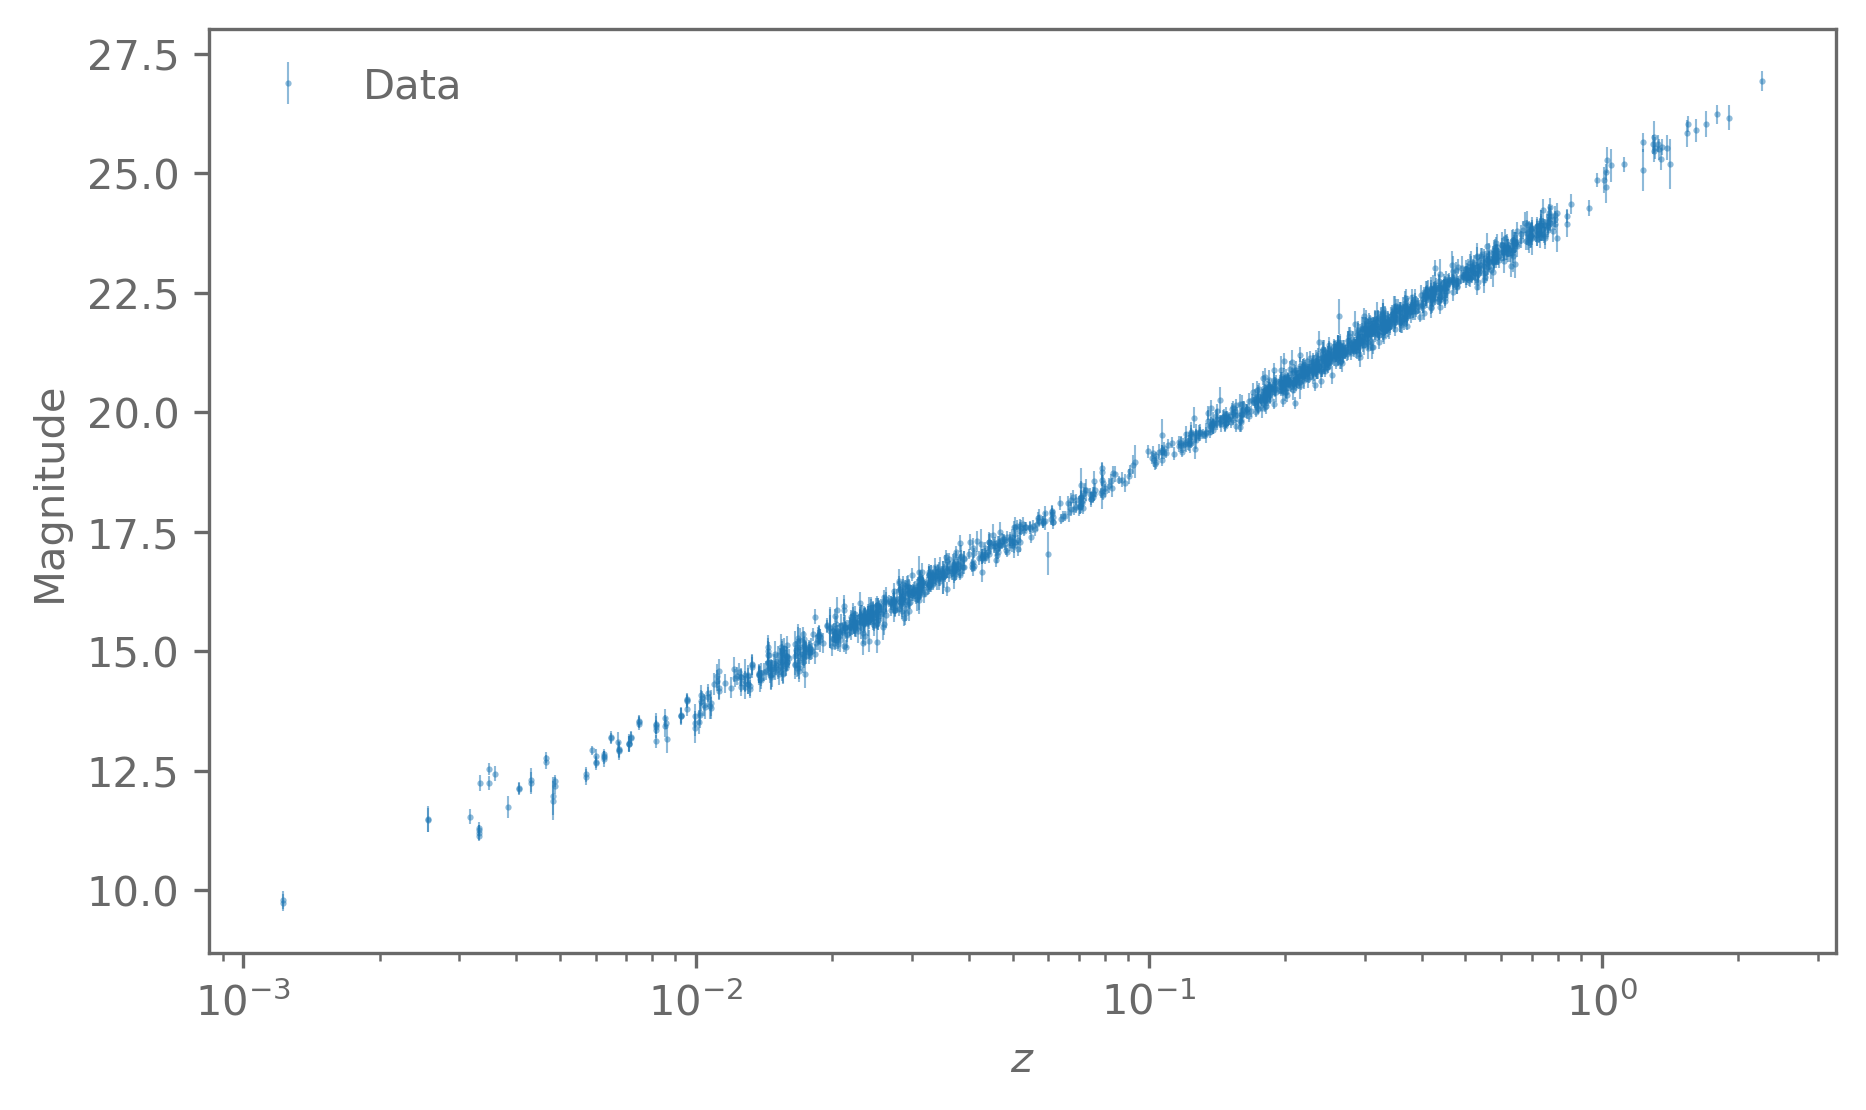

In [18]:
# A helper function to plot the data
def plot_data(models=None, data=None, subtract_y=None):
    sort_idx = np.argsort(pantheon_sh0es.z)
    x = pantheon_sh0es.z
    y = pantheon_sh0es.data
    y_err = pantheon_sh0es.data_error

    fig, ax = bayesian_stats_course_tools.analyse.plot_data(
        x=x[sort_idx], y=y[sort_idx], y_err=y_err[sort_idx],
        fmt=".", markersize=1, alpha=0.5, elinewidth=0.5,
        models=models, subtract_y=subtract_y,
        axis_labels=["$z$", "Magnitude"]
    )
    ax.set_xscale("log")
    return fig, ax

plot_data();

Define the model and the likelihood.

The model is relatively simple here. It mostly computes the distance given a redshift and from that the magnitude.

As in the paper we assume a Gaussian likelihood:

In [23]:
# We use a Gaussian likelihood
# To make sampling easier later on, we use the
# tensorflow-probability implementation
def create_likelihood_distribution(params):
    mu = pantheon_sh0es.model(params)

    return tfd.MultivariateNormalTriL(
        loc=mu, scale_tril=pantheon_sh0es.covariance_cholesky.astype(jnp.float64)
    )

In [24]:
# Set up some initial parameters
param_names = ["Omega_m", "H0", "M"]
param_labels = [r"\Omega_m", "H_0", "M"]

params_initial = dict(
    Omega_m=0.3, H0=70.0, M=-19.0
)
# Some functions require an array instead of a dict
params_initial_flat = jnp.array([params_initial[i] for i in param_names])

initial_likelihood = create_likelihood_distribution(params_initial)

# Create a mock data vector from the likelihood
key, subkey = random.split(random.PRNGKey(42))
mock_data = initial_likelihood.sample(seed=subkey)

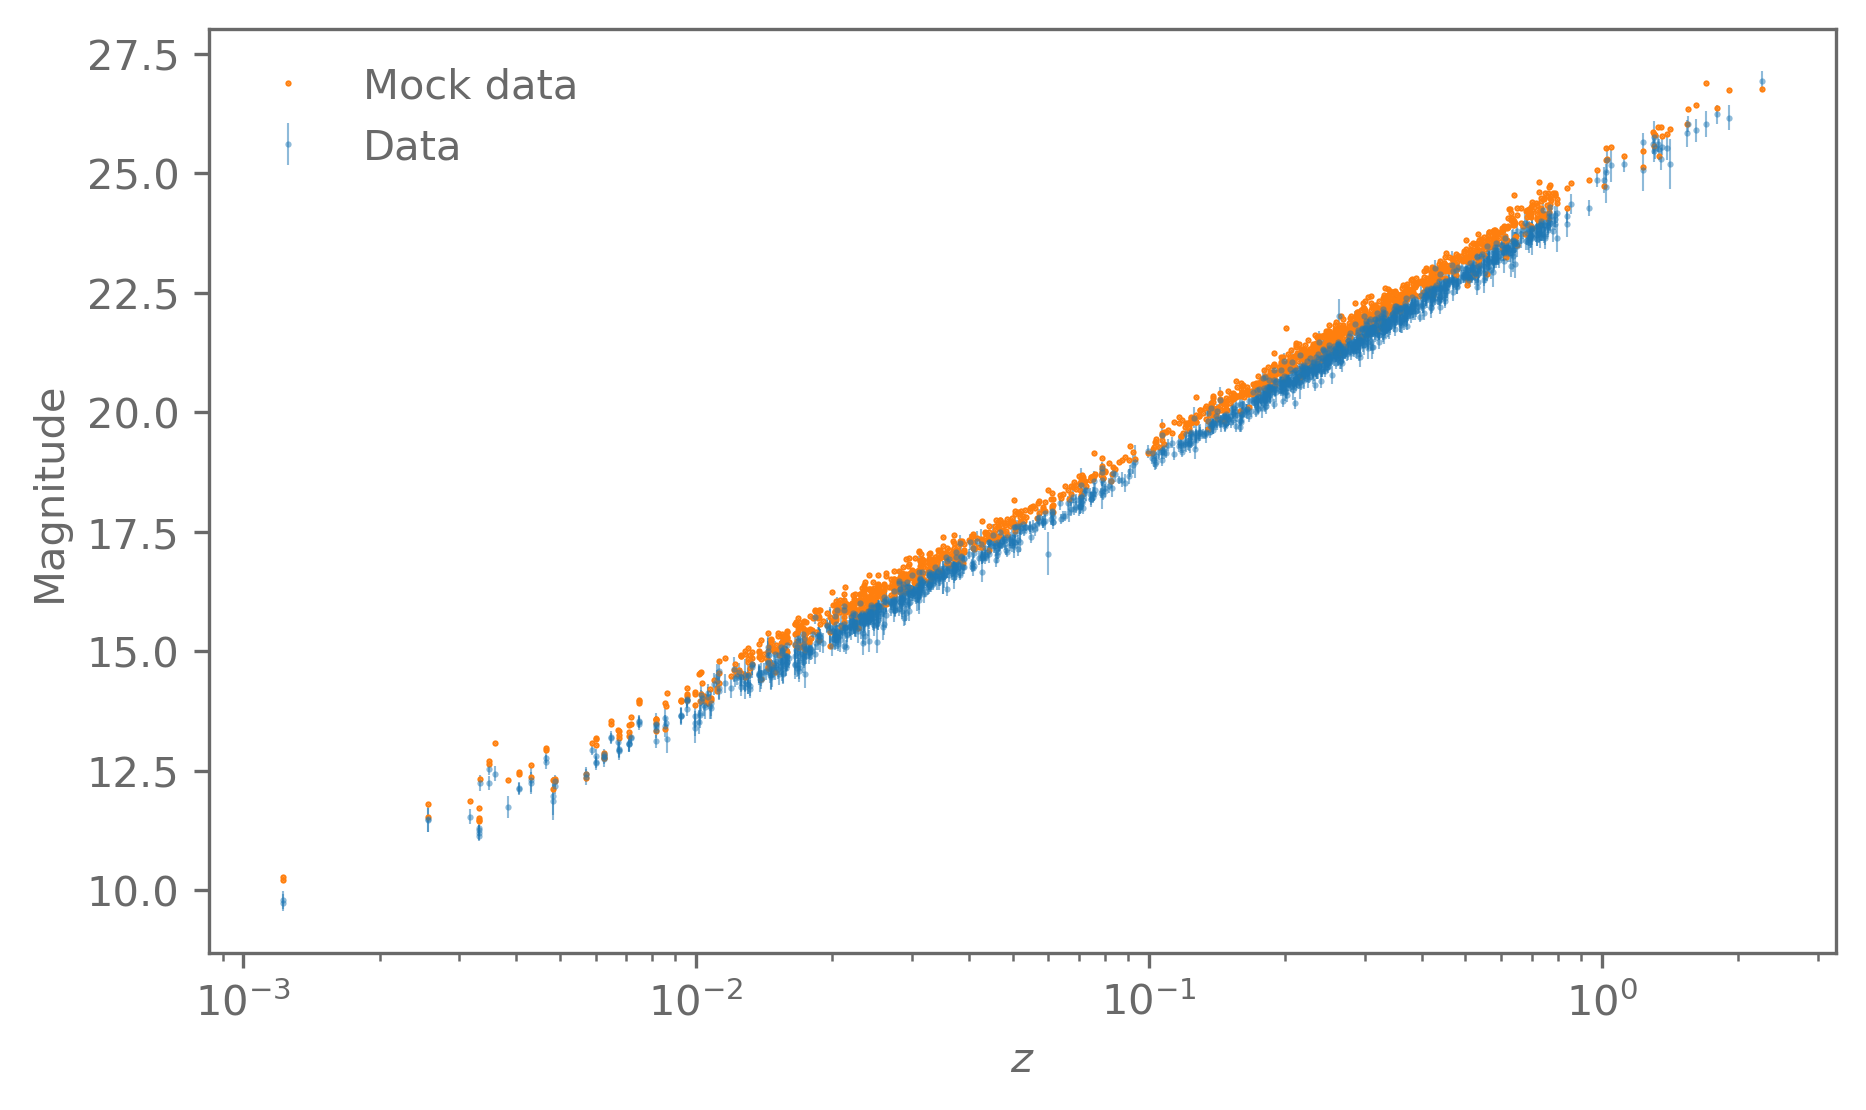

In [25]:
plot_data(models=[
    dict(x=pantheon_sh0es.z, y=mock_data,
         style=dict(ls="none", marker=".", ms=1, label="Mock data"))]
);

Now that we have defined a likelihood, let us make some forecasts on what the parameter constraints will look like user Fisher information matrices.

In [26]:
# Define a function that evaluates the log likelihood at a set of parameters,
# for a fixed datavector
def log_likelihood_fixed_data(params):
    log_L = create_likelihood_distribution(
        params
    ).log_prob(mock_data)
    return log_L

# Use JAX's autodiff tools to get the Hessian of the log likelihood
log_likelihood_hessian = jit(hessian(log_likelihood_fixed_data))

In [27]:
# Evaluate the Hessian and put it into a matrix form
# We need to do this because the parameters are a dict here.
# If they were in a flat array, we would get a matrix directly
log_likelihood_hessian_matrix = log_likelihood_hessian(params_initial)
fisher_matrix = -jnp.array(
    [[log_likelihood_hessian_matrix[i][j] for i in param_names]
     for j in param_names]
)

Expected uncertainty on Omega_m: 0.018
Expected uncertainty on H0: 1.03


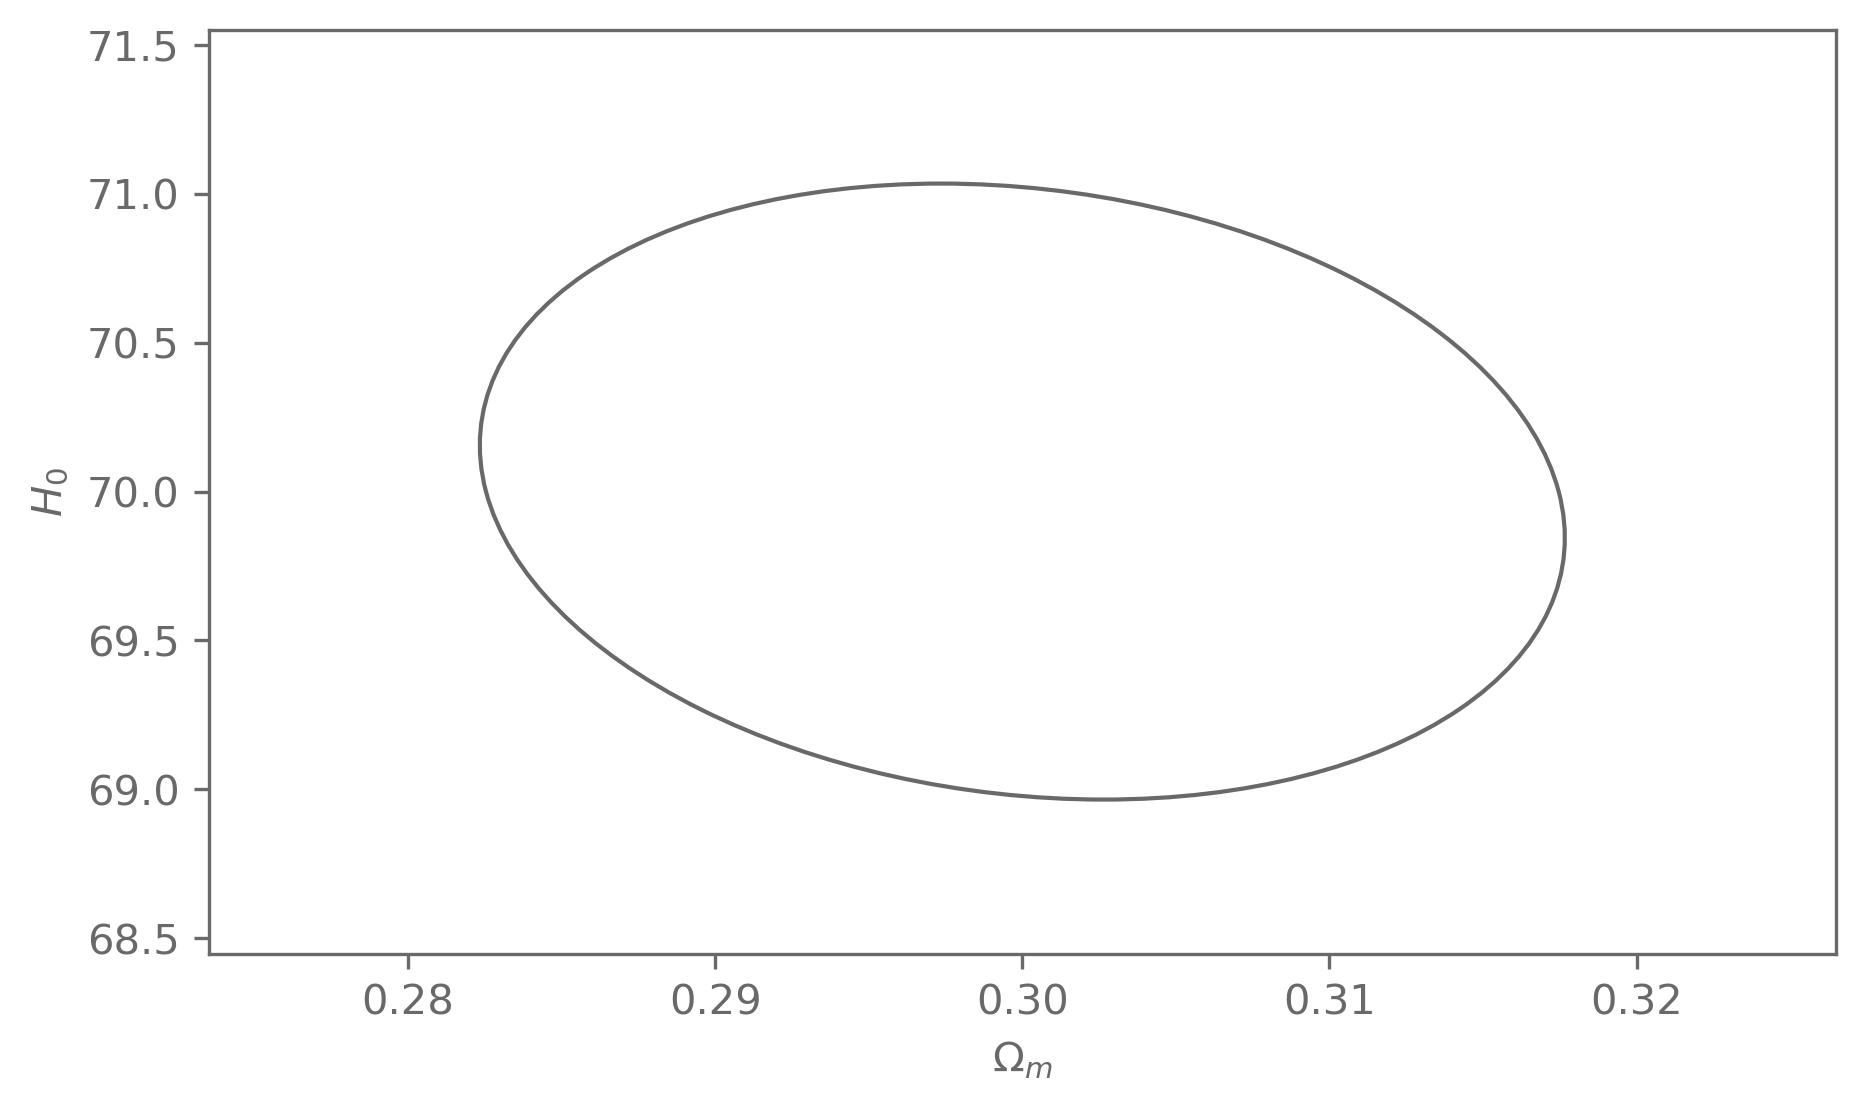

In [28]:
cov = np.linalg.inv(fisher_matrix)
ax = plot_contours(cov=cov[:2, :2], pos=params_initial_flat[:2], fill=False)
ax.set_xlabel("$\Omega_m$")
ax.set_ylabel("$H_0$")

print(f"Expected uncertainty on Omega_m: {np.sqrt(cov[0,0]):.3f}")
print(f"Expected uncertainty on H0: {np.sqrt(cov[1,1]):.2f}")

Now define our priors and posterior to do things like finding the MAP and sampling from the posterior.

In [29]:
H_0_prior = tfd.Uniform(low=55, high=91)
Omega_m_prior = tfd.Uniform(low=0.1, high=0.9)
M_prior = tfd.Uniform(low=-20, high=-18)

def log_prior(params):
    return (
        H_0_prior.log_prob(params["H0"]) 
        + Omega_m_prior.log_prob(params["Omega_m"]) 
        + M_prior.log_prob(params["M"])
    )

def log_posterior(params, data):
    likelihood = create_likelihood_distribution(params)
    return likelihood.log_prob(data) + log_prior(params)

Because we are using JAX, we can just-in-time compile the posterior function, making it fast.


In [30]:
%timeit jit(log_posterior)(params_initial, pantheon_sh0es.data).block_until_ready()

7.35 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Find the MAP.

In [31]:
# We minimise the negative log posterior to find the maximum of the posterior
def neg_log_posterior(params, data):
    return -log_posterior(params, data)

solver = jaxopt.ScipyMinimize(fun=jit(neg_log_posterior), method="L-BFGS-B")
solution = solver.run(params_initial, data=pantheon_sh0es.data)
MAP_params = solution.params

print("MAP")
for name, value in MAP_params.items():
    print(f"{name} = {value:.3f}")

MAP
H0 = 73.739
M = -19.244
Omega_m = 0.326


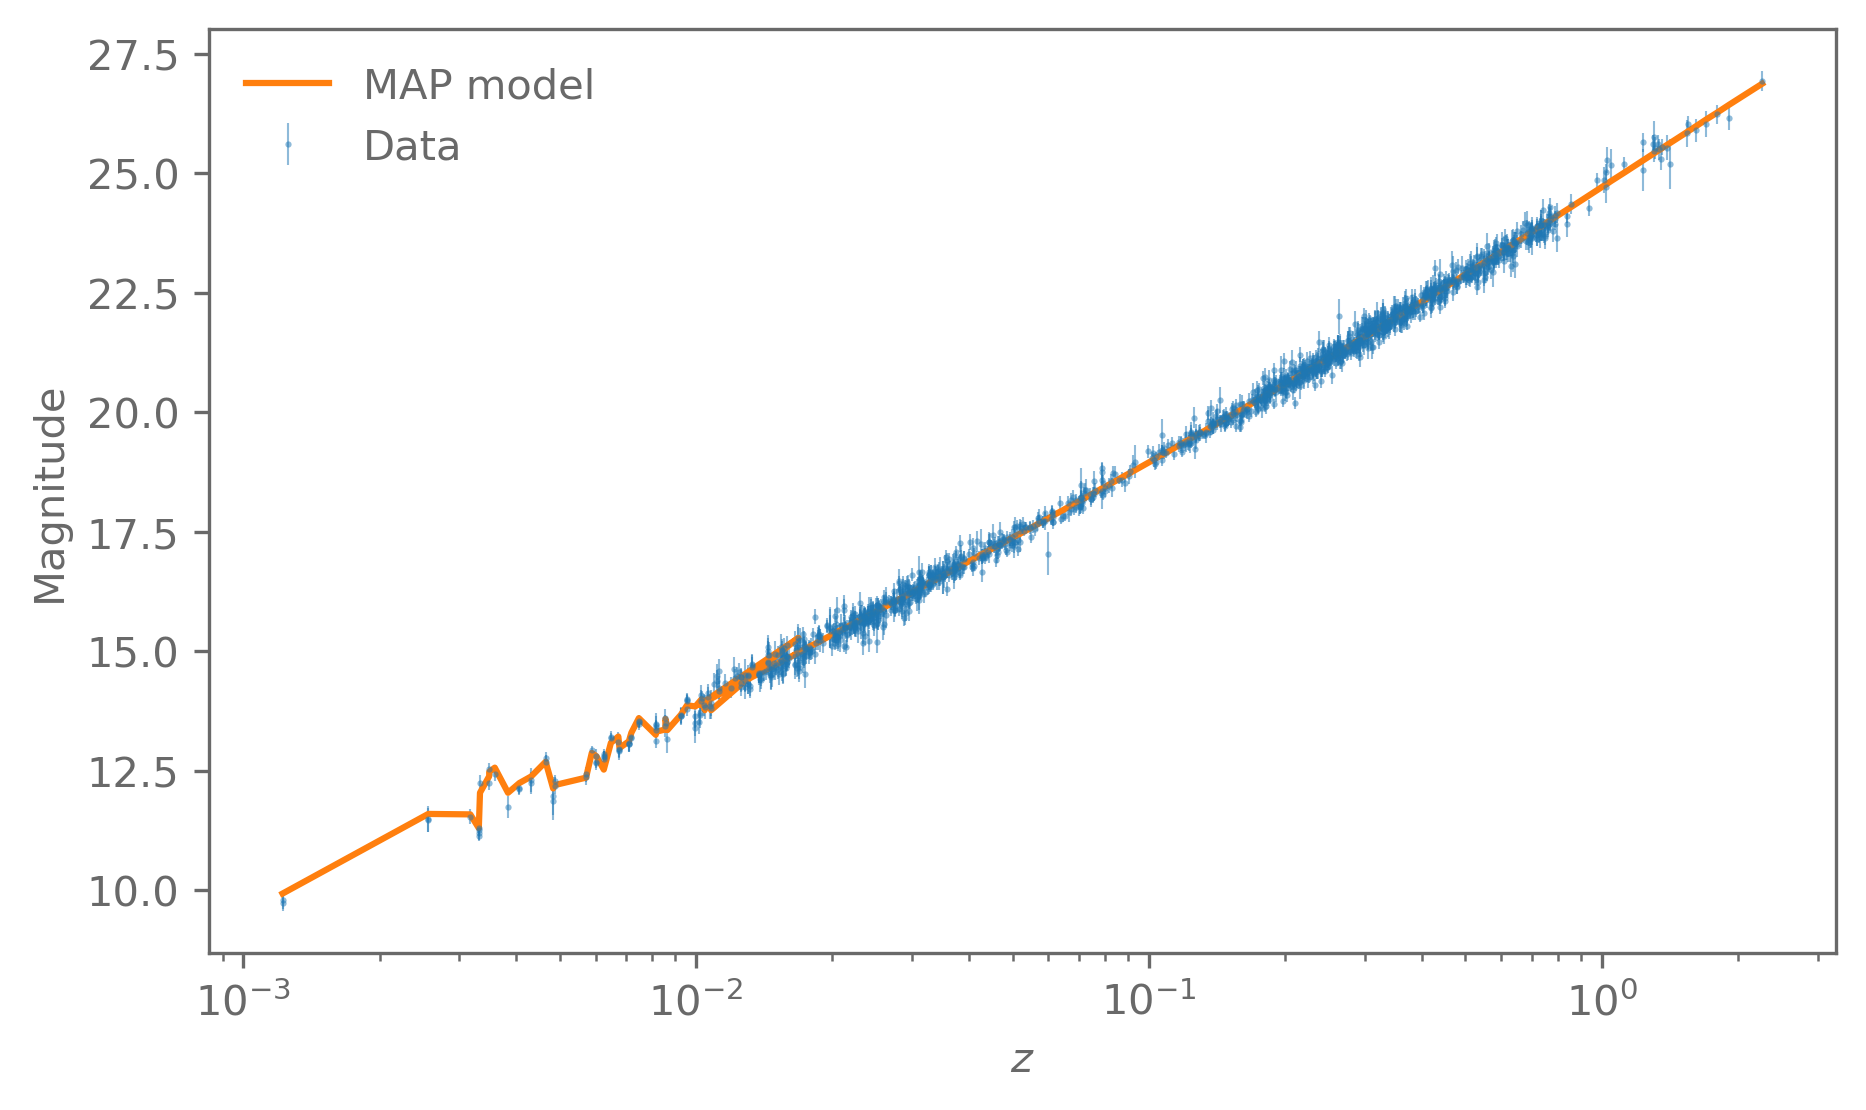

In [32]:
plot_data(
    models=[dict(x=pantheon_sh0es.z, y=pantheon_sh0es.model(MAP_params), style=dict(label="MAP model"))]
);

Now to sampling from the posterior. 

Here we use emcee to do the sampling. This wastes some of potential from JAX by not using gradients but the combination of vectorising the posterior evaluation and just-in-time compilation is still very powerful.

In [35]:
# Make wrapper around the posterior so it works with emcee
def log_posterior_wrapper(params):
    log_p = log_posterior(
        dict(Omega_m=params[0], H0=params[1], M=params[2]),
        data=pantheon_sh0es.data
    )
    # Use cond here to allow jit compilation
    log_p = cond(jnp.isfinite(log_p), lambda x: x, lambda x: -jnp.inf, log_p)
    return log_p

# Set the configuration for emcee
n_param = len(params_initial)
n_walker = 3*n_param
n_step = 5000

# Set initial positons for the walkers
params_init_walkers = (
    params_initial_flat + np.random.normal(scale=0.01, size=(n_walker, n_param))
)

sampler = emcee.EnsembleSampler(
    nwalkers=n_walker, ndim=n_param,
    log_prob_fn=jit(vmap(log_posterior_wrapper)),
    vectorize=True
)
state = sampler.run_mcmc(params_init_walkers, nsteps=n_step, progress=True)

100%|██████████| 5000/5000 [01:16<00:00, 65.26it/s]


We now need to check that the chain is well behaved and converged.

First check the integrated auto-correlation time to get a sense of how many independent samples we got in our chain.

In [36]:
# Check the autocorrelation times
print("Integrated auto-correlation time")
for name, iat in zip(param_names, sampler.get_autocorr_time()):
    print(f"{name}: {iat:.1f}")

Integrated auto-correlation time
Omega_m: 47.5
H0: 47.3
M: 42.2


Remove a few auto-correlation times for the burn-in and thin out the chain.

In [37]:
max_autocorr = max(sampler.get_autocorr_time())
burn_in = int(5*max_autocorr)
thin = int(max_autocorr/2)

chain_per_walker = sampler.get_chain(discard=burn_in, thin=thin)
chain = sampler.get_chain(discard=burn_in, thin=thin, flat=True)

Make a trace plot to check for weird chain behaviour.

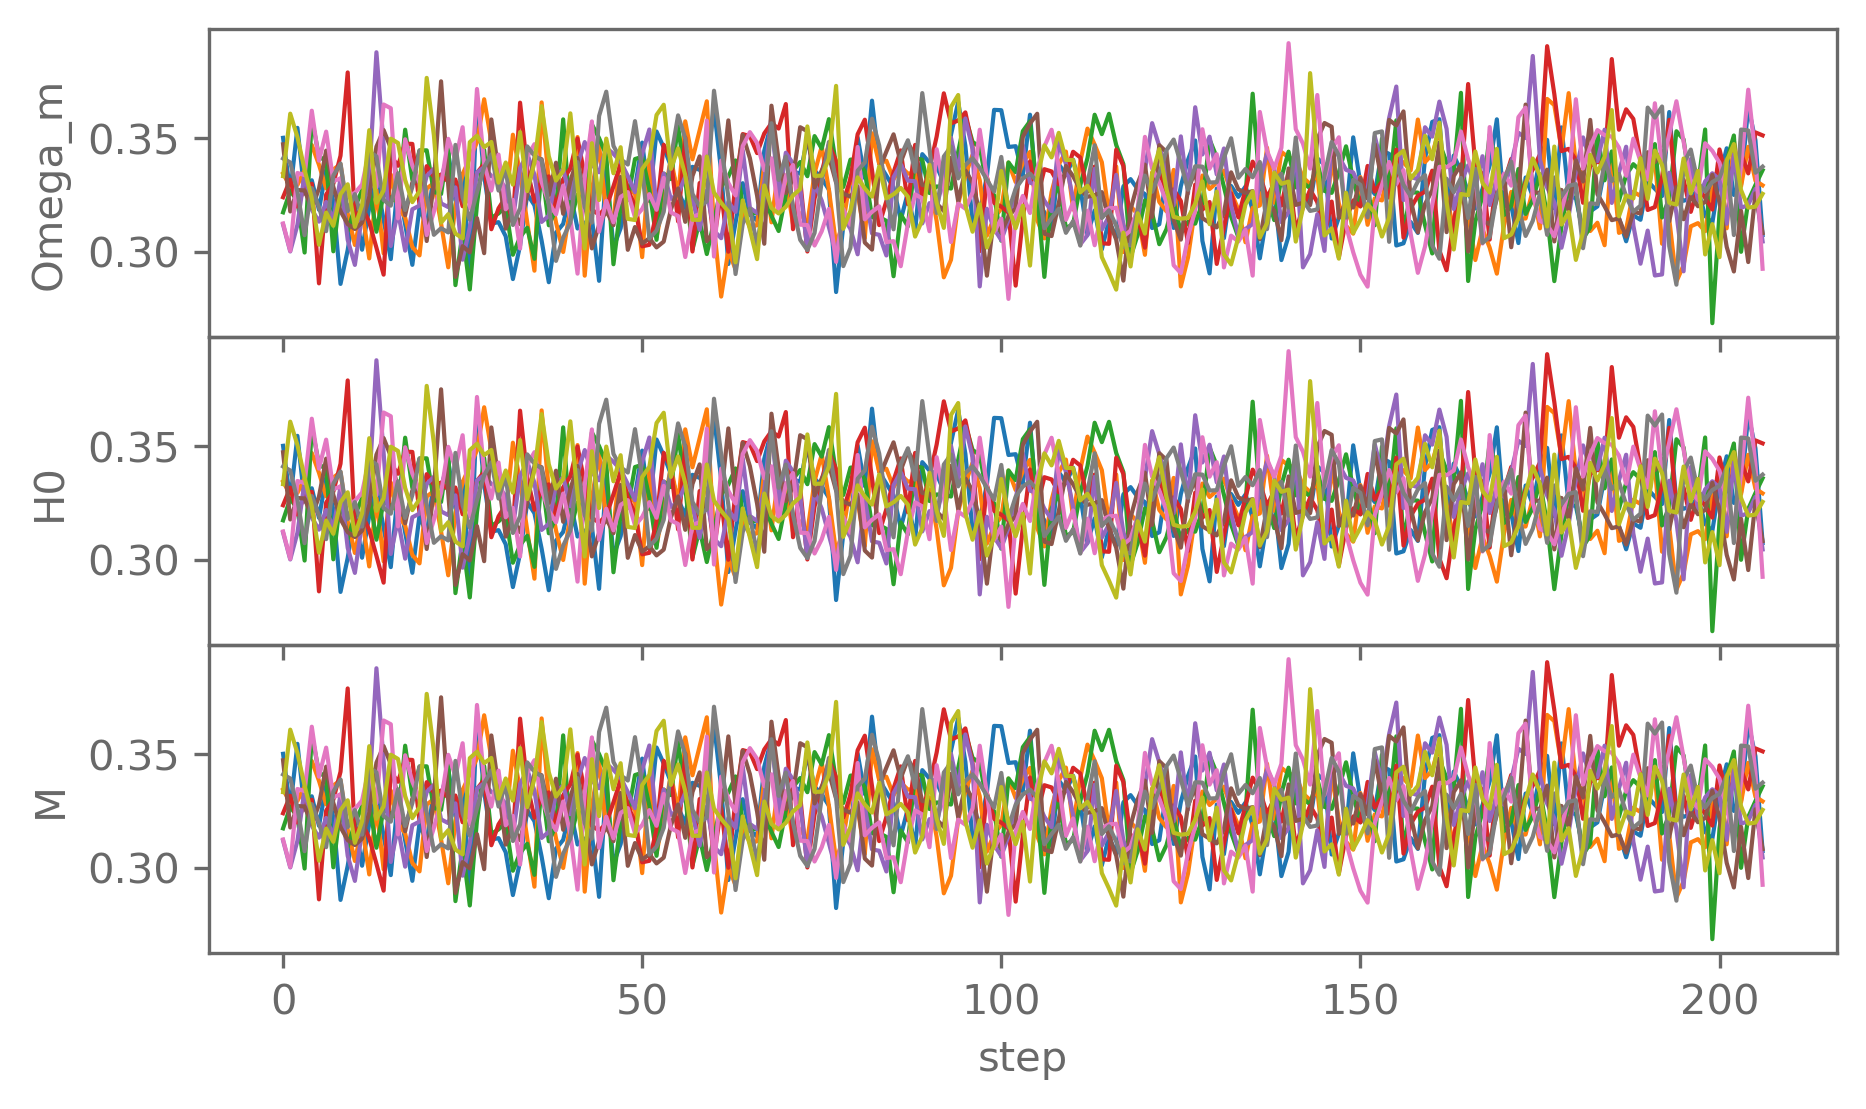

In [38]:

# Plot the tracer of the chain, this time for all the walkers
fig, ax = plt.subplots(len(params_initial), 1, sharex=True)
plt.subplots_adjust(hspace=0)

for i, name in enumerate(param_names):
    for j in range(n_walker):
        ax[i].plot(chain_per_walker[:, j, 0], lw=1, color=f"C{j}")
    ax[i].set_ylabel(name)

ax[-1].set_xlabel("step");

The chain looks good, so now to plot the chain and get summary statistics on the posterior.

We use `getdist` here, since it has a bit more features than `corner` and makes prettier plots.

In [39]:
getdist_samples = getdist.MCSamples(
    samples=chain,
    names=param_names,
    labels=param_labels,
    # We tell getdist what the ranges of the parameters are to avoid plotting
    # artefacts at the boundaries
    ranges={"Omega_m": (0.1, 0.9),
            "H0": (55, 91),
            "M": (-20, -18)},
    label="MCMC samples"
)

Removed no burn in


In [40]:
g = getdist.plots.get_single_plotter()

# Add the Fisher forecast to the plot to see how well we did in forecasting
# the constraints
MAP_params_flat = jnp.array([MAP_params[i] for i in param_names])
fisher_forecast = getdist.gaussian_mixtures.GaussianND(
    mean=MAP_params_flat, cov=cov, names=param_names,
    label="Fisher forecast"
)

<Figure size 1800x1350 with 0 Axes>

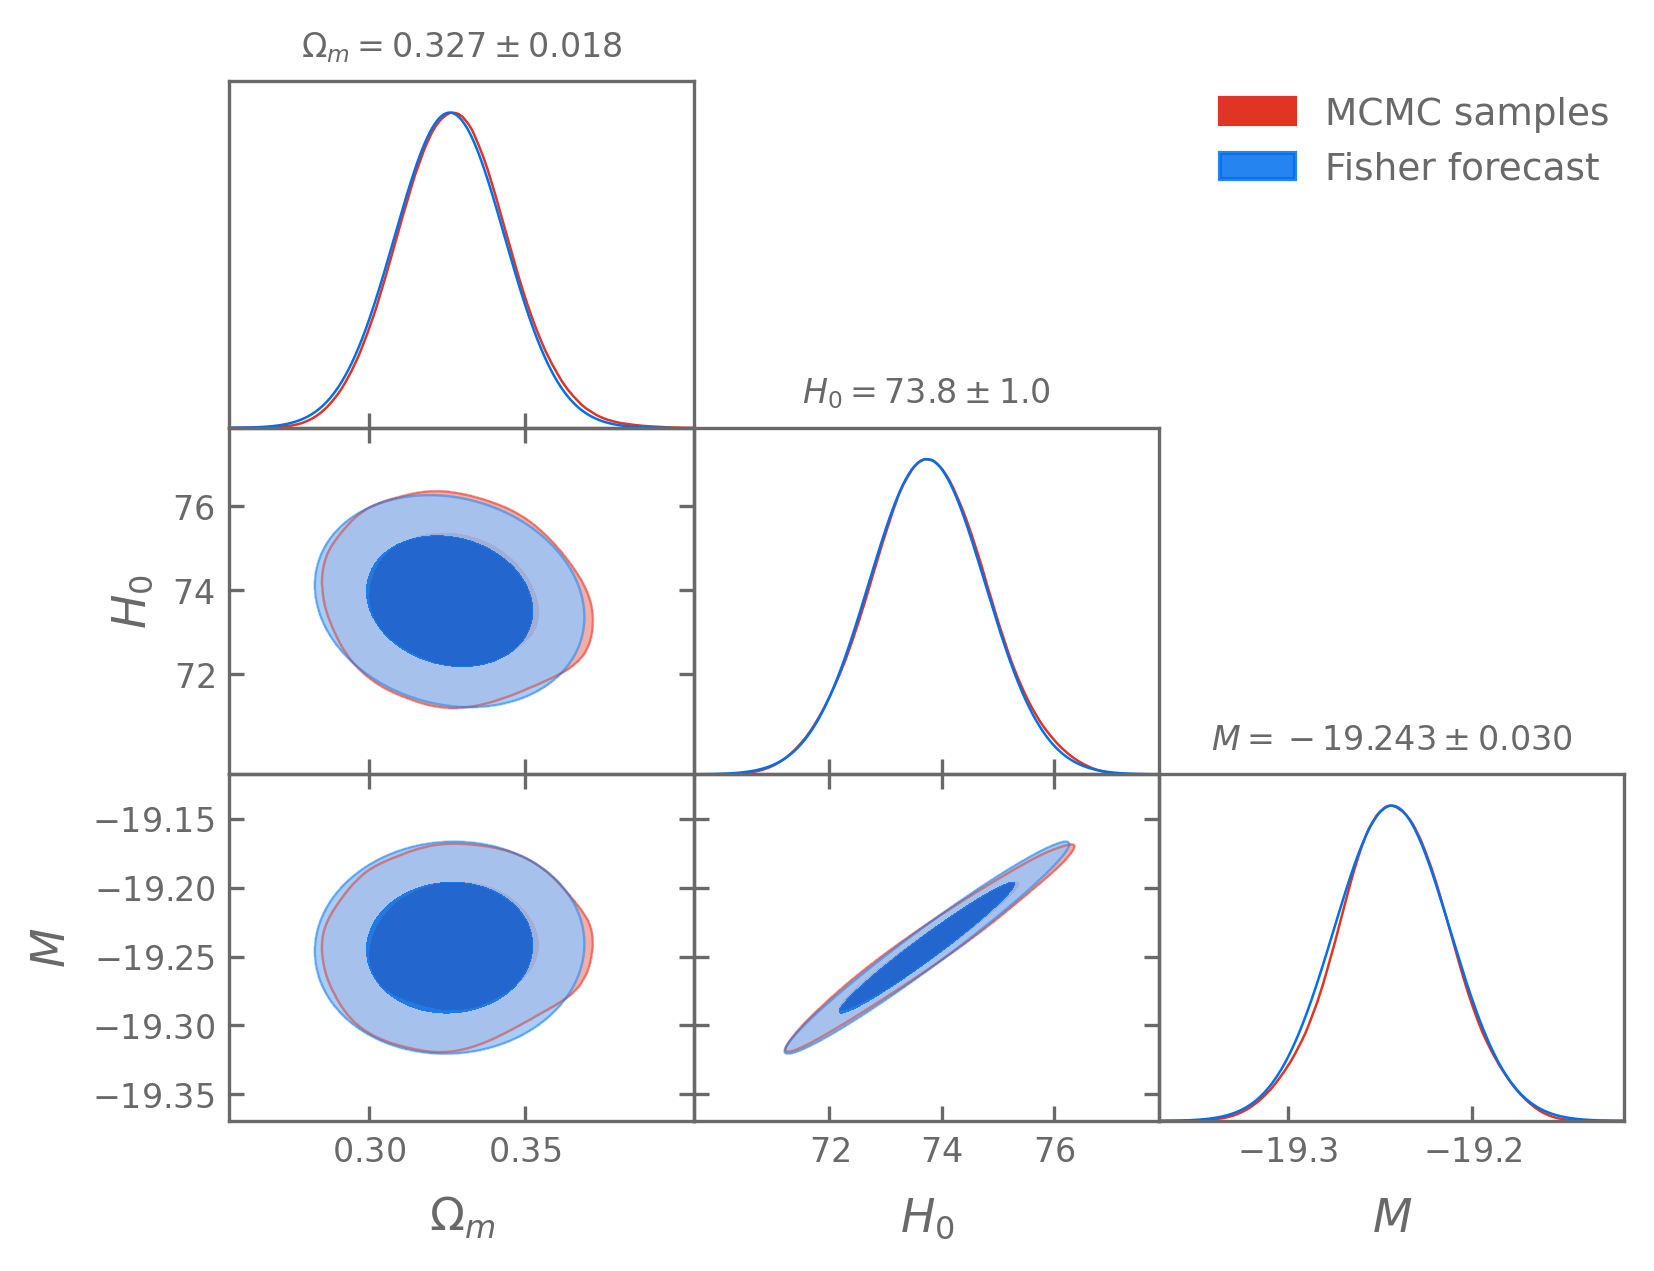

In [41]:
g.triangle_plot([getdist_samples, fisher_forecast], filled=True, title_limit=1)

We need to check that our model fits the data.

We first create samples from the posterior predictive distribution.

In [42]:
# Use 500 samples from the chain
posterior_predictive_samples = chain[np.random.choice(chain.shape[0], 500)]

# Define function that samples the likelihood given a set of parameter
def sample_ppd(params, seed):
    return create_likelihood_distribution(
        dict(Omega_m=params[0], H0=params[1], M=params[2])
    ).sample(seed=seed)

keys = random.split(random.PRNGKey(42), posterior_predictive_samples.shape[0])

# Use JAX vmap to get PPD samples for all the parameter samples
ppd = jit(vmap(sample_ppd))(posterior_predictive_samples, keys)

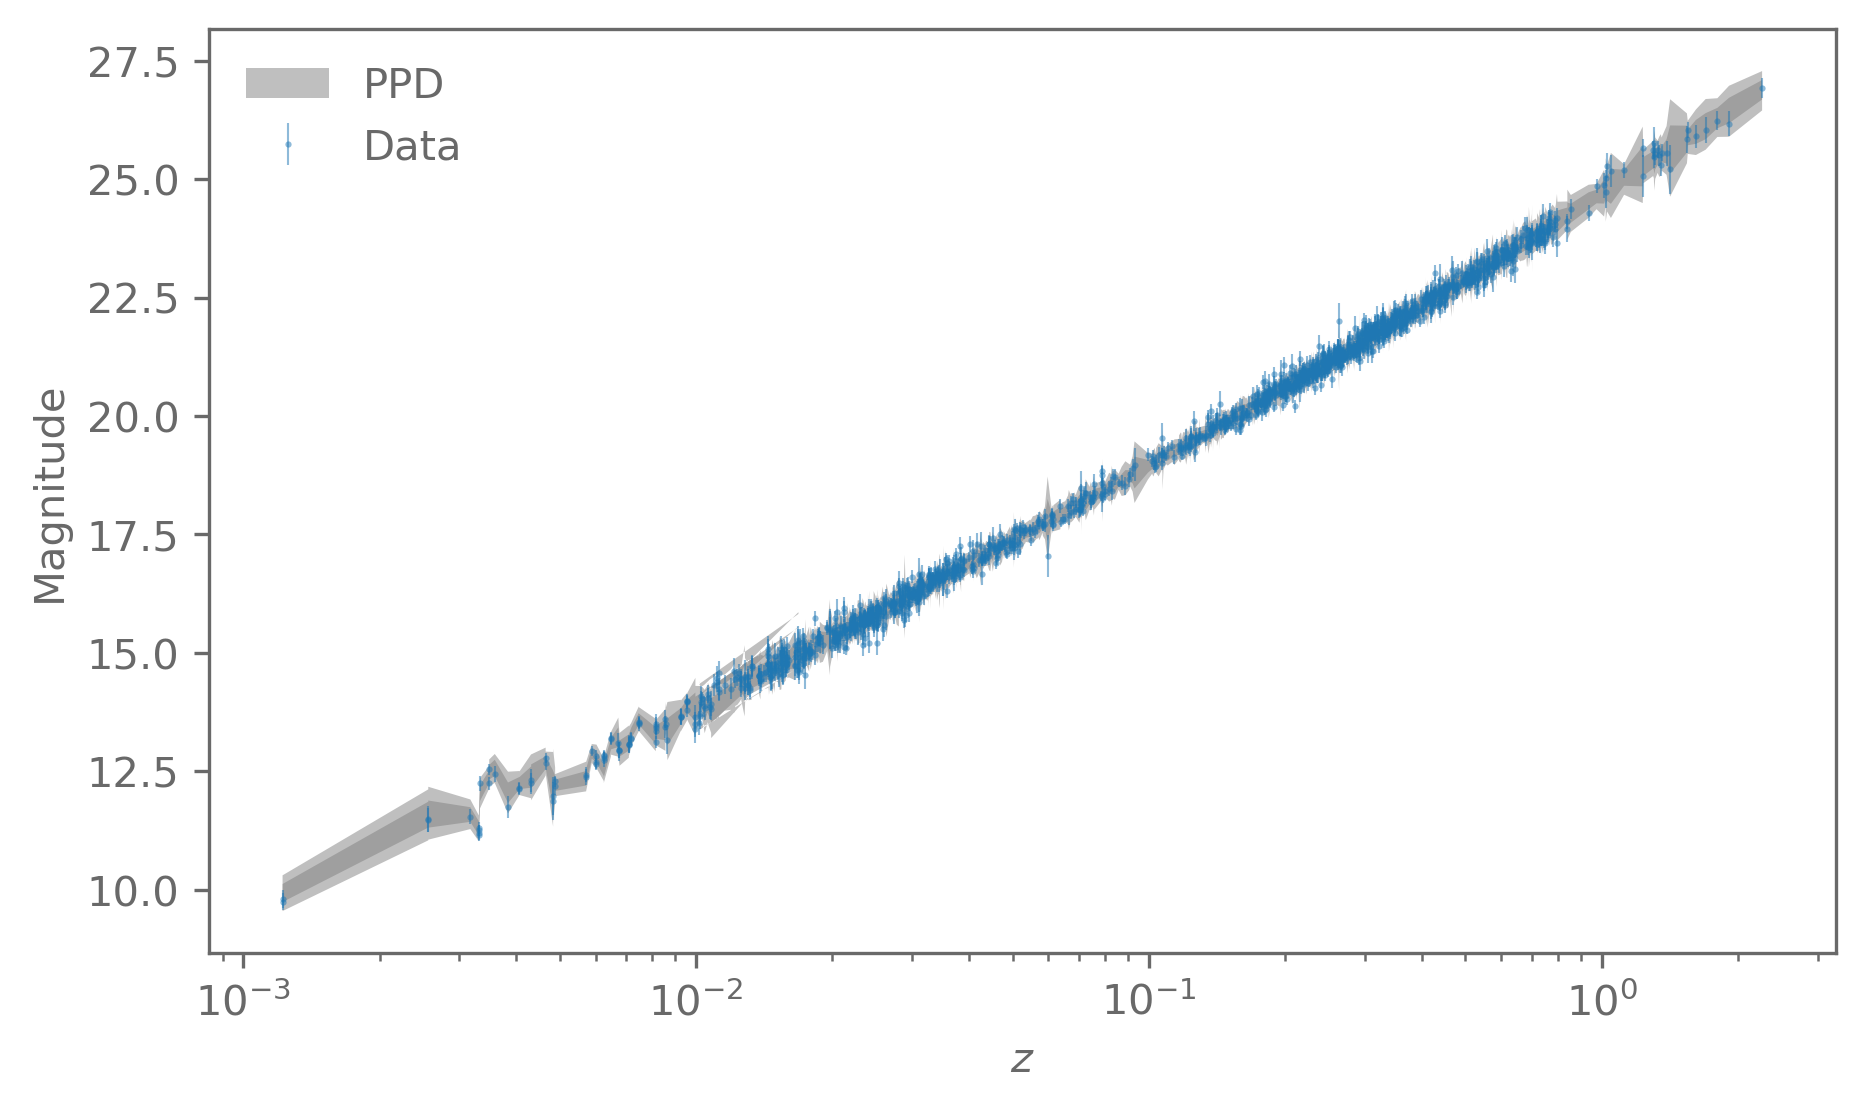

In [43]:
ppd_quantiles = np.quantile(ppd, q=[0.025, 0.16, 0.84, 0.975], axis=0)

plot_data(
    models=[dict(x=pantheon_sh0es.z,
                 lower=ppd_quantiles[0], upper=ppd_quantiles[-1],
                 style=dict(facecolor="grey", alpha=0.5, label="PPD")),
            dict(x=pantheon_sh0es.z,
                 lower=ppd_quantiles[1], upper=ppd_quantiles[-2],
                 style=dict(facecolor="grey", alpha=0.5))],
);

Now check the goodness of fit by comparing a test statistic over the PPD to that to the observed data.

In [44]:
# We use a statistic that basically the chi-square statistic
def test_statistic(data, params):
    chi2 = -2*create_likelihood_distribution(
        dict(Omega_m=params[0], H0=params[1], M=params[2])
    ).log_prob(data)
    return chi2

# vmap makes it easy to get the our samples of the test statistic
t_rep = jit(vmap(test_statistic))(ppd, posterior_predictive_samples)
t_data = jit(vmap(test_statistic, in_axes=[None, 0]))(
    pantheon_sh0es.data, posterior_predictive_samples
)

Find the fraction of where the test statistic on the PPD is larger than on the observed data.

In [45]:
print(f"PTE PPD = {(t_rep > t_data).sum()/t_rep.shape[0]:.3f}")

PTE PPD = 1.000


That does not look too good. The observed data is too likely in a sense.

Let us check the histogram of $T(y^\mathrm{rep},\theta) - T(y^\mathrm{obs},\theta)$.

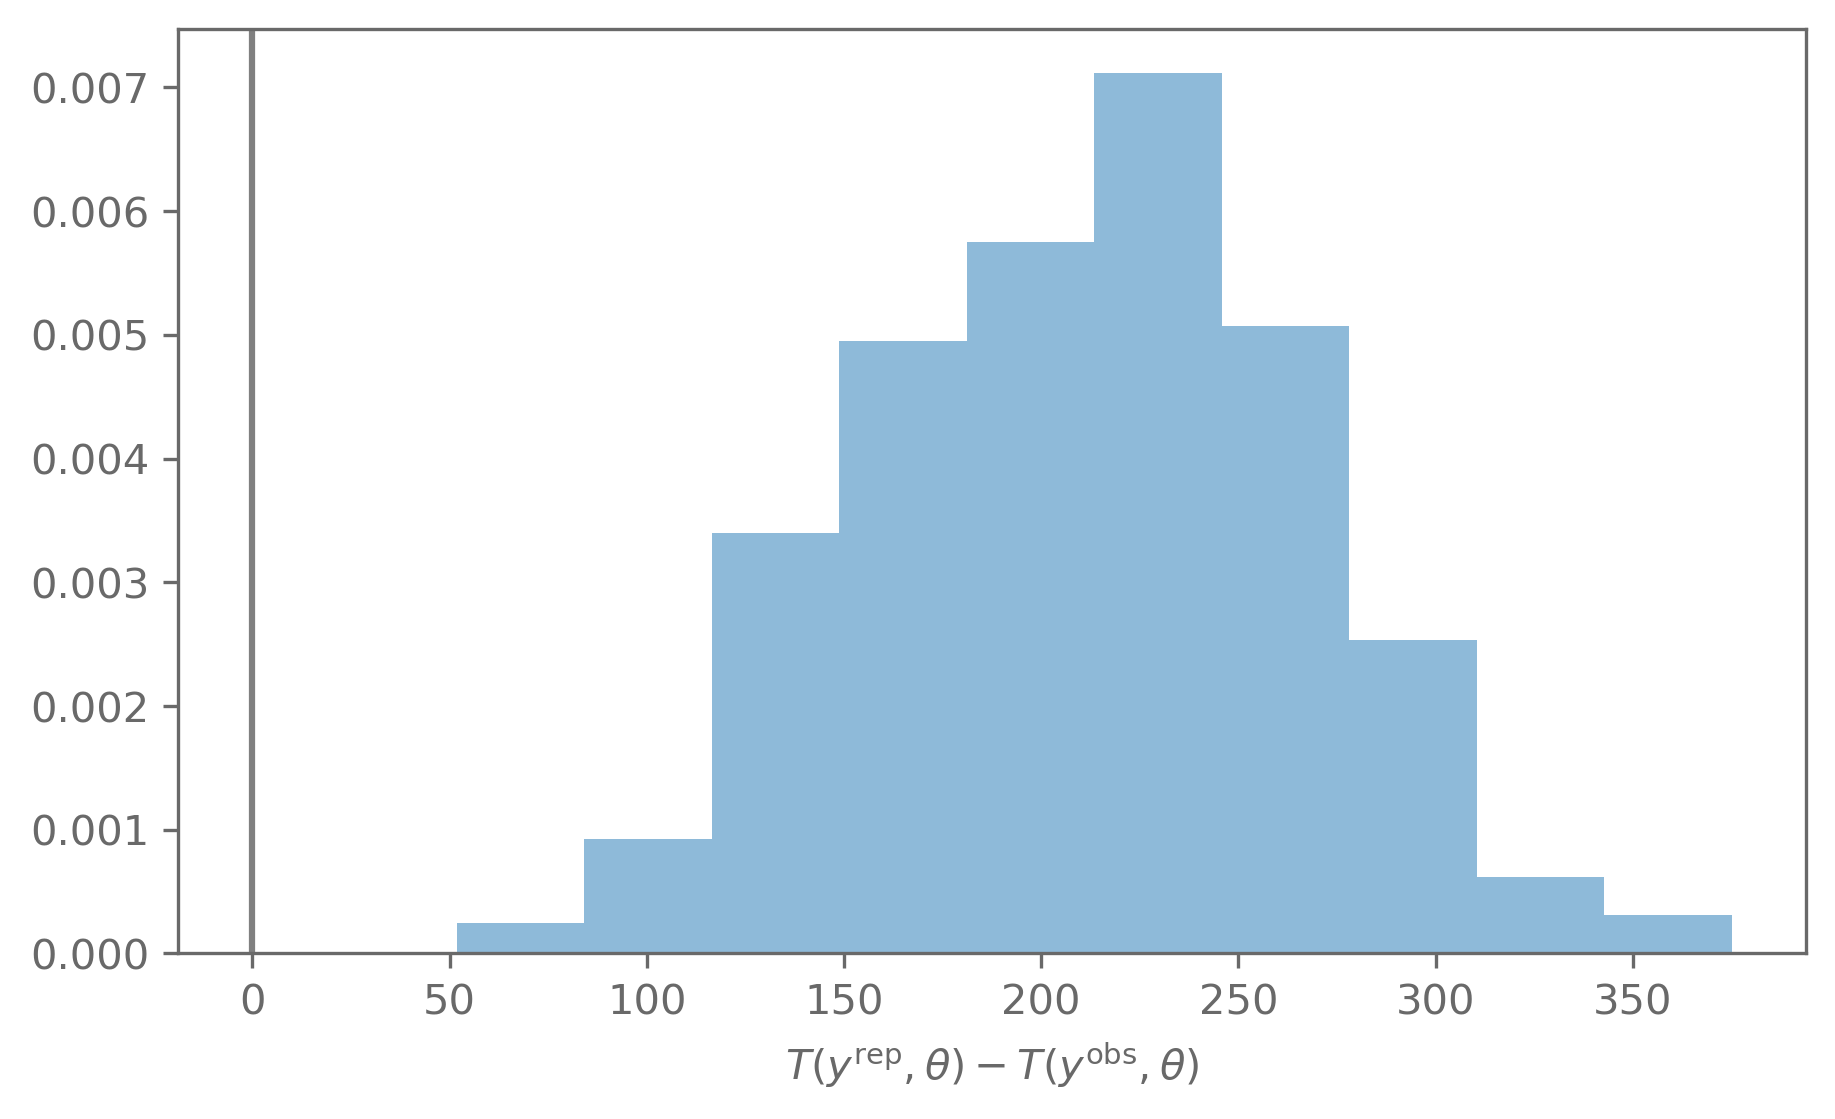

In [46]:
plt.hist(t_rep - t_data, density=True, alpha=0.5)
plt.axvline(0, c="grey")
plt.xlabel(r"$T(y^\mathrm{rep},\theta) - T(y^\mathrm{obs},\theta)$");

This is suspicious. Let us check the $\chi^2$ statistic to see if that gives us a similar result.

In [47]:
import scipy.stats

mu = pantheon_sh0es.model(MAP_params)
r = pantheon_sh0es.data - mu

chi2 = r @ pantheon_sh0es.inverse_covariance @ r

print(f"PTE chi-square: {scipy.stats.chi2(df=pantheon_sh0es.data.shape[0]-3).sf(chi2):.4f}")

PTE chi-square: 0.9999


Something is not right. The first suspect is the covariance.

We used the STAT+SYS covariance here. That means the covariance includes the systematic uncertainty on top of the statistical uncertainty. This could explain the very high PTE on the test statistic.

Doing the analysis with the STATONLY covariance lowers the PTE a little bit but it is still much too high. 



That means we need to go back and have a detailed look at the data and how the covariance is estimated.

For that we might want to focus on different parts of the data. 
For example, the current data vector has parts where the distances are assumed to be known (the Cepheid calibrators), while for the rest the distances are computed based on the parameters and redshifts. 

The data also come from different surveys. We could look at if any of the surveys has data that looks suspicious and does not fit into the model.

Once we have fixed the covariance and get acceptable fits, we can then move on the model comparison.

For example, here we assumed the Universe is spatially flat and that dark energy is a cosmological constant.

We can analyse the same data but with different models to assess whether a Universe with curvature or a form of dark energy with a different equation of state is preferred by the data.

For that we would use nested sampling to get the evidences, and cross-check with the DIC and WAIC information criteria.

## Project and reports

If you want credit points, the grade is going to be based on a small research project & report.
- The goal of the report is to show that you learned something about statistics in this course.
    - This can either cover a data analysis end-to-end, demonstrating the techniques we covered.
    - Alternatively, looking in-depths into an algorithm or the theory behind a statistical tool is also an option.
- Format: like a journal article (specifically a Letter):
    - Professional presentation, i.e. using LaTeX, nice plots
    - Proper references and appropriate structure
    - Page limit of 5 (excluding references)
    - There is a good example report on Moodle
- Group work is allowed. Conditions:
    - Max group size: 5
    - Everyone in the group gets the same grade
    - Everyone needs to contribute to both the report and the analysis
    - The report needs to include a contribution statement that briefly describes what each member has done

Deadline is 2024/07/19 at 23:59 CEST.

The report should be like a mini semester project or MSc thesis.

The structure should follow that of a scientific research article:
- Intro:
    - Context: why is this interesting? Particularly in the context of (Bayesian) statistics.
    - Literature: what have others done?
- Methods:
    - What are you doing in the project? How are you doing it?
- Results:
    - What are the results of the analysis or the tests you have done? How well does your method work?
- Discussion:
    - Why are the results interesting? Any unexpected results? Where to go from here?

# Thanks!

Please fill out the course evaluation & let me know if you have any feedback on what to do differently.

